# Predcition of Hospital Admission Related to Cold with Cough

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to cold with cough (cough_cold).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'cough_cold_date_'+str(i), 'cough_cold_ab_date_'+str(i), 'cough_cold_ab_type_'+str(i),
                   'incdt_cough_cold_date_'+str(i), 'admitted_cough_cold_date_'+str(i), 'sgss_gp_cov_cough_cold_date_'+str(i)]]
    
    #drop rows with no cough_cold reord
    datum = datum[datum['cough_cold_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with cough_cold_i
    datum = datum[datum['sgss_gp_cov_cough_cold_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'cough_cold_date_'+str(i): 'cough_cold_date', 'cough_cold_ab_date_'+str(i): 'cough_cold_ab_date', 
                           'cough_cold_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_cough_cold_date_'+str(i): 'incdt_cough_cold_date', 'incdt_cough_cold_type_'+str(i): 'incdt_cough_cold_type',
                           'admitted_cough_cold_date_'+str(i): 'admitted_cough_cold_date',
                           'sgss_gp_cov_cough_cold_date_'+str(i): 'sgss_gp_cov_cough_cold_date'},
                inplace=True)
    
    return datum

In [5]:
#preparation of data for cox models
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    data_req = data[vars+vars_countinuous+vars_output]
    #encoding categorical data for cox models
    data_enc = data_req[vars+vars_countinuous].reset_index()
    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [6]:
#summary table of observation counts
def make_summary_table(infection, infection_type, data):
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
#summary table of hospitalised cases
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    #encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()

    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [8]:
#build cox models
def cox_model_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [9]:
#save coefficients (betas) and calculate sum of betas
def cox_betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    #save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    #transpose and sort covariates and coefficients
    covariatesT = covariates.T
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data

    #further cleaning up covariates to make them compatible with the encoded data
    covariates_list = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    covariates_list = [value.replace("'", "") for value in covariates_list] #removes double quotation mark 

    #match covariates_list (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(covariates_list)] 
    data = data.sort_index(axis = 1) #sort 

    #multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')

    #sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    
    #predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  

    #sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    #separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))

    #select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    #save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [10]:
def cox_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    #analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [11]:
#calculate and plot calibrations of cox models
def cox_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']

    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T 
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [12]:
#print outputs of cox models
def cox_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    #calculate concordance index
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    #save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [13]:
#build cox model with an additional binary variable for antibiotics
def cox_model_abs_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + cough_cold_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics 
    #predict cumulative hazard in day 30 in train dataset
    prob_pred_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_train.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_train['bins'] = pd.qcut(prob_pred_train['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_train = pd.merge(prob_pred_train, data_train[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_train = prob_pred_train.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_train.columns = ['bins', 'pred_mean_train', 'pred_sum', 'pred_count', 'ab_prob_mean_train', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin = prob_pred_groupby_bin_train[['pred_mean_train', 'ab_prob_mean_train']]

    #predict cumulative hazard in day 30 in test dataset
    prob_pred_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T
    prob_pred_test.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_test['bins'] = pd.qcut(prob_pred_test['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_test = pd.merge(prob_pred_test, data_test[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_test = prob_pred_test.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_test.columns = ['bins', 'pred_mean_test', 'pred_sum', 'pred_count', 'ab_prob_mean_test', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin[['pred_mean_test', 'ab_prob_mean_test']] = prob_pred_groupby_bin_test[['pred_mean_test', 'ab_prob_mean_test']]

    #save binned prob_pred, train and test combined
    prob_pred_groupby_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_groupby_bin_'+infection+'_'+infection_type+'.csv', index=False)

    return cph, data_train, data_test

In [14]:
#build cox model with an additional categorical variable for antibiotics
def cox_model_ab_type_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [15]:
#build cox models stratified with sex categories 
def cox_model_strat_sex_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + cough_cold_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [16]:
#build cox models stratified with age categories
def cox_model_strat_age_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + cough_cold_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [17]:
#build cox models stratified with time period categories 
def cox_model_strat_period_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + cough_cold_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [18]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_cough_cold.csv.gz')

In [19]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [20]:
#process 20 cough_colds and concatenate them 
data_cough_cold_1 = proc_infec_data(data,1)
data_cough_cold_2 = proc_infec_data(data,2)
data_cough_cold_3 = proc_infec_data(data,3)
data_cough_cold_4 = proc_infec_data(data,4)
data_cough_cold_5 = proc_infec_data(data,5)
data_cough_cold_6 = proc_infec_data(data,6)
data_cough_cold_7 = proc_infec_data(data,7)
data_cough_cold_8 = proc_infec_data(data,8)
data_cough_cold_9 = proc_infec_data(data,9)
data_cough_cold_10 = proc_infec_data(data,10)
data_cough_cold_11 = proc_infec_data(data,11)
data_cough_cold_12 = proc_infec_data(data,12)
data_cough_cold_13 = proc_infec_data(data,13)
data_cough_cold_14 = proc_infec_data(data,14)
data_cough_cold_15 = proc_infec_data(data,15)
data_cough_cold_16 = proc_infec_data(data,16)
data_cough_cold_17 = proc_infec_data(data,17)
data_cough_cold_18 = proc_infec_data(data,18)
data_cough_cold_19 = proc_infec_data(data,19)
data_cough_cold_20 = proc_infec_data(data,20)

data_cough_cold = pd.concat([data_cough_cold_1, data_cough_cold_2, data_cough_cold_3, data_cough_cold_4, data_cough_cold_5, data_cough_cold_6, data_cough_cold_7, data_cough_cold_8, data_cough_cold_9, data_cough_cold_10, data_cough_cold_11, data_cough_cold_12, data_cough_cold_13, data_cough_cold_14, data_cough_cold_15, data_cough_cold_16, data_cough_cold_17, data_cough_cold_18, data_cough_cold_19, data_cough_cold_20])
data_cough_cold.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [21]:
##add variable season
#convert data types
data_cough_cold['cough_cold_date'] = data_cough_cold['cough_cold_date'].astype('datetime64[ns]')
data_cough_cold['admitted_cough_cold_date'] = data_cough_cold['admitted_cough_cold_date'].astype('datetime64[ns]')
data_cough_cold.died_date = data_cough_cold.died_date.astype('datetime64[ns]')
data_cough_cold.deregistered_date = data_cough_cold.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_cough_cold['date'] = data_cough_cold['cough_cold_date'] 
data_cough_cold['date'] = data_cough_cold['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_cough_cold with today's date in year and month
data_cough_cold = data_cough_cold[data_cough_cold['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_cough_cold = data_cough_cold[data_cough_cold['date'] != last_1_month_date_y_m]
data_cough_cold = data_cough_cold[data_cough_cold['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of cough_cold records
data_cough_cold['season'] = np.nan
data_cough_cold['date_month'] = pd.DatetimeIndex(data_cough_cold['date']).month

conditions = [
    (data_cough_cold['date_month'] >= 3) & (data_cough_cold['date_month'] <= 5),
    (data_cough_cold['date_month'] >= 6) & (data_cough_cold['date_month'] <= 8),
    (data_cough_cold['date_month'] >= 9) & (data_cough_cold['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_cough_cold['season'] = np.select(conditions, choices, default='winter')

In [22]:
#add variable time period
data_cough_cold.loc[(data_cough_cold['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_cough_cold.loc[((data_cough_cold['date'] >= '2020-01') & (data_cough_cold['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_cough_cold.loc[(data_cough_cold['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [23]:
#scenario 1
#not hosped (nothing happened)
data_cough_cold.loc[data_cough_cold['admitted_cough_cold_date'].isnull(), 'event_cough_cold_admitted'] = 0

In [24]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_cough_cold['delta_cough_cold_admitted'] = (data_cough_cold['admitted_cough_cold_date'] - data_cough_cold['cough_cold_date']).dt.days
data_cough_cold.loc[((data_cough_cold['delta_cough_cold_admitted'] >= 0) & (data_cough_cold['delta_cough_cold_admitted'] <= 30)), 'event_cough_cold_admitted'] = 1

#scenario 2
#drop whoever was admitted before cough_cold consultation, i.e. negative value for delta_cough_cold_admitted
data_cough_cold = data_cough_cold[~(data_cough_cold['delta_cough_cold_admitted'] < 0)]

In [25]:
#scenario 3
#censor died patients
data_cough_cold['delta_admitted_died'] = (data_cough_cold['died_date'] - data_cough_cold['admitted_cough_cold_date']).dt.days
data_cough_cold.loc[data_cough_cold['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_cough_cold.loc[((data_cough_cold['delta_admitted_died'] >= 0) & (data_cough_cold['delta_admitted_died'] <= 30)), 'event_cough_cold_admitted'] = 0

#scenario 3
#censor deregistered patients
data_cough_cold['delta_admitted_deregistered'] = (data_cough_cold['deregistered_date'] - data_cough_cold['admitted_cough_cold_date']).dt.days
data_cough_cold.loc[data_cough_cold['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_cough_cold.loc[((data_cough_cold['delta_admitted_deregistered'] > 0) & (data_cough_cold['delta_admitted_deregistered'] <= 30)), 'event_cough_cold_admitted'] = 0

#agg scenario 3s
data_cough_cold['delta_admitted_died_deregistered'] = data_cough_cold['delta_admitted_deregistered'].combine_first(data_cough_cold['delta_admitted_died'])
data_cough_cold.loc[data_cough_cold['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [26]:
#scenario 1
#any other patients (nothing happened)
data_cough_cold['event_cough_cold_admitted'] = data_cough_cold['event_cough_cold_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_cough_cold['duration_cough_cold_admitted'] = data_cough_cold['delta_cough_cold_admitted'].combine_first(data_cough_cold['delta_admitted_died_deregistered'])
data_cough_cold['duration_cough_cold_admitted'] = data_cough_cold['duration_cough_cold_admitted'].replace(np.NaN, 30)
data_cough_cold.loc[(data_cough_cold['duration_cough_cold_admitted'] > 30), 'duration_cough_cold_admitted'] = 30

#give value 1 to event_cough_cold_admitted if duration_cough_cold_admitted is greater or equal to 0 and less than 30
data_cough_cold.loc[((data_cough_cold['duration_cough_cold_admitted'] >= 0) & (data_cough_cold['duration_cough_cold_admitted'] < 30)), 'event_cough_cold_admitted'] = 1

#drop any rows with value 0 in duration column
data_cough_cold = data_cough_cold[~(data_cough_cold['duration_cough_cold_admitted'] == 0)]

In [27]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_cough_cold.loc[((data_cough_cold['delta_cough_cold_admitted'] > 0) & (data_cough_cold['delta_cough_cold_admitted'] < 30)), 'event_cough_cold_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [28]:
#drop anybody with age less than 18 or 0!
data_cough_cold = data_cough_cold[~(data_cough_cold['age'] < 18)] 
data_cough_cold['age'][data_cough_cold['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_cough_cold = data_cough_cold[data_cough_cold['age_cat'] != '0-4']
data_cough_cold = data_cough_cold[data_cough_cold['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_cough_cold['bmi'][data_cough_cold['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_cough_cold['bmi'] = data_cough_cold['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_cough_cold['antibacterial_brit'][data_cough_cold['antibacterial_brit'] < 0] = np.nan

In [29]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_cough_cold = data_cough_cold.replace({"sex": dict_sex})
data_cough_cold = data_cough_cold.replace({"smoking_status": dict_smoking})

In [30]:
#drop rows with missing region
if ('region' in data_cough_cold.columns) and (data_cough_cold['region'].isnull().sum() > 0):
   data_cough_cold = data_cough_cold[data_cough_cold['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_cough_cold.columns) and (data_cough_cold['antibacterial_brit'].isnull().sum() > 0):
    data_cough_cold['antibacterial_brit'] = data_cough_cold['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_cough_cold.columns) and (data_cough_cold['ethnicity'].isnull().sum() > 0):
    data_cough_cold['ethnicity'] = data_cough_cold['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking_status' in data_cough_cold.columns) and (data_cough_cold['smoking_status'].isnull().sum() > 0):
    data_cough_cold['smoking_status'] = data_cough_cold['smoking_status'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_cough_cold.columns) and (data_cough_cold['imd'].isnull().sum() > 0):
    data_cough_cold['imd'] = data_cough_cold['imd'].fillna(0)

In [31]:
#missing values of bmi assign 5 and 0; categorise bmi
data_cough_cold['bmi_cat'] = 5

for idx, x in enumerate(data_cough_cold['bmi_cat']):
    if data_cough_cold.iat[idx, data_cough_cold.columns.get_loc('bmi')] >= 30:
        data_cough_cold.iat[idx, data_cough_cold.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_cough_cold.iat[idx, data_cough_cold.columns.get_loc('bmi')] >= 25) and (data_cough_cold.iat[idx, data_cough_cold.columns.get_loc('bmi')] < 30):
        data_cough_cold.iat[idx, data_cough_cold.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_cough_cold.iat[idx, data_cough_cold.columns.get_loc('bmi')] >= 18.5) and (data_cough_cold.iat[idx, data_cough_cold.columns.get_loc('bmi')] < 25):
        data_cough_cold.iat[idx, data_cough_cold.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_cough_cold.iat[idx, data_cough_cold.columns.get_loc('bmi')] < 18.5:
        data_cough_cold.iat[idx, data_cough_cold.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_cough_cold.columns) and (data_cough_cold['bmi_cat'].isnull().sum() > 0):
    data_cough_cold['bmi_cat'] = data_cough_cold['bmi_cat'].fillna(0)

In [32]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_cough_cold.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_cough_cold['ab_type_cat'] = np.where(data_cough_cold['ab_type'].isin(ab_series[mask].index),'other',data_cough_cold['ab_type'])
#assign no to non ab users
data_cough_cold.loc[data_cough_cold['cough_cold_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_cough_cold['ab_type_cat'] = data_cough_cold['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [33]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_cough_cold = data_cough_cold.replace({"sex": dict_sex})
data_cough_cold = data_cough_cold.replace({"ethnicity": dict_ethnicity})
data_cough_cold = data_cough_cold.replace({"smoking_status": dict_smoking})
data_cough_cold = data_cough_cold.replace({"imd": dict_imd})
data_cough_cold = data_cough_cold.replace({"bmi_cat": dict_bmi})
data_cough_cold = data_cough_cold.replace({"flu_vaccine": dict_flu})
data_cough_cold = data_cough_cold.replace({"region": dict_region})
data_cough_cold = data_cough_cold.replace({"age_cat": dict_age})
data_cough_cold = data_cough_cold.replace({"ab_type_cat": dict_ab_type})

### 2-5- categorising and assigning max value for continuous variables

In [34]:
#categorise CCI
data_cough_cold['CCI_cat'] = pd.cut(data_cough_cold['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_cough_cold['antibacterial_brit'].clip(0, data_cough_cold['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

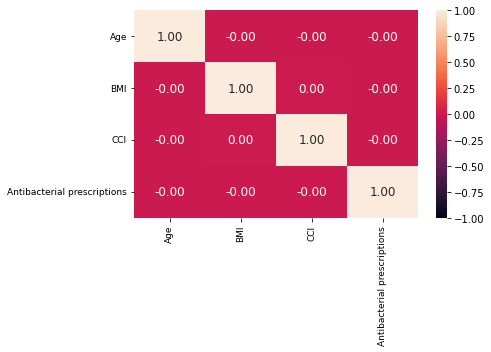

In [35]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_cough_cold[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_cough_cold/corr_cough_cold.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [36]:
data_cough_cold = data_cough_cold[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                                   'antibacterial_brit', 'cough_cold_ab_date', 'ab_type_cat', 'incdt_cough_cold_date', 'date', 'period',
                                   'event_cough_cold_admitted', 'duration_cough_cold_admitted'
                                    ]]

In [37]:
#incident and prevalent infection 
data_cough_cold_incdt = data_cough_cold[data_cough_cold['incdt_cough_cold_date'] == 0]
data_cough_cold_prevl = data_cough_cold[data_cough_cold['incdt_cough_cold_date'] == 1]
#switch variable cough_cold_ab_date into a binary variable
data_cough_cold_incdt[['cough_cold_ab_date']] = data_cough_cold_incdt[['cough_cold_ab_date']].where(data_cough_cold_incdt[['cough_cold_ab_date']].isnull(), 1).fillna(0).astype(int)
data_cough_cold_prevl[['cough_cold_ab_date']] = data_cough_cold_prevl[['cough_cold_ab_date']].where(data_cough_cold_prevl[['cough_cold_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_cough_cold_incdt_males = data_cough_cold_incdt[data_cough_cold_incdt['sex'] == 'male']
data_cough_cold_incdt_females = data_cough_cold_incdt[data_cough_cold_incdt['sex'] == 'female']
data_cough_cold_prevl_males = data_cough_cold_prevl[data_cough_cold_prevl['sex'] == 'male']
data_cough_cold_prevl_females = data_cough_cold_prevl[data_cough_cold_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_cough_cold_incdt_15_24 = data_cough_cold_incdt[data_cough_cold_incdt['age_cat'] == '15_24']
data_cough_cold_incdt_25_34 = data_cough_cold_incdt[data_cough_cold_incdt['age_cat'] == '25_34']
data_cough_cold_incdt_35_44 = data_cough_cold_incdt[data_cough_cold_incdt['age_cat'] == '35_44']
data_cough_cold_incdt_45_54 = data_cough_cold_incdt[data_cough_cold_incdt['age_cat'] == '45_54']
data_cough_cold_incdt_55_64 = data_cough_cold_incdt[data_cough_cold_incdt['age_cat'] == '55_64']
data_cough_cold_incdt_65_74 = data_cough_cold_incdt[data_cough_cold_incdt['age_cat'] == '65_74']
data_cough_cold_incdt_75_more = data_cough_cold_incdt[data_cough_cold_incdt['age_cat'] == '75_more']
data_cough_cold_prevl_15_24 = data_cough_cold_prevl[data_cough_cold_prevl['age_cat'] == '15_24']
data_cough_cold_prevl_25_34 = data_cough_cold_prevl[data_cough_cold_prevl['age_cat'] == '25_34']
data_cough_cold_prevl_35_44 = data_cough_cold_prevl[data_cough_cold_prevl['age_cat'] == '35_44']
data_cough_cold_prevl_45_54 = data_cough_cold_prevl[data_cough_cold_prevl['age_cat'] == '45_54']
data_cough_cold_prevl_55_64 = data_cough_cold_prevl[data_cough_cold_prevl['age_cat'] == '55_64']
data_cough_cold_prevl_65_74 = data_cough_cold_prevl[data_cough_cold_prevl['age_cat'] == '65_74']
data_cough_cold_prevl_75_more = data_cough_cold_prevl[data_cough_cold_prevl['age_cat'] == '75_more']

#incident and prevalent infection stratified by time period categories
data_cough_cold_incdt_prepandemic = data_cough_cold_incdt[data_cough_cold_incdt['date'] <= '2019-12']
data_cough_cold_incdt_during_pandemic = data_cough_cold_incdt[(data_cough_cold_incdt['date'] >= '2020-03') & (data_cough_cold_incdt['date']<= '2021-03')]
data_cough_cold_incdt_post_2nd_lockdown = data_cough_cold_incdt[data_cough_cold_incdt['date'] <= '2021-04']
data_cough_cold_prevl_prepandemic = data_cough_cold_prevl[data_cough_cold_prevl['date'] <= '2019-12']
data_cough_cold_prevl_during_pandemic = data_cough_cold_prevl[(data_cough_cold_prevl['date'] >= '2020-03') & (data_cough_cold_prevl['date']<= '2021-03')]
data_cough_cold_prevl_post_2nd_lockdown = data_cough_cold_prevl[data_cough_cold_prevl['date'] <= '2021-04']

# no antibiotics and incident hospital admission
data_cough_cold_no_abs_incdt = data_cough_cold[data_cough_cold['cough_cold_ab_date'].isnull()]
data_cough_cold_no_abs_incdt = data_cough_cold_no_abs_incdt[data_cough_cold_no_abs_incdt['incdt_cough_cold_date'] == 0]

# with antibiotics and incident hospital admission
data_cough_cold_abs_incdt = data_cough_cold[data_cough_cold['cough_cold_ab_date'].notnull()]
data_cough_cold_abs_incdt = data_cough_cold_abs_incdt[data_cough_cold_abs_incdt['incdt_cough_cold_date'] == 0]

# no antibiotics and prevalent hospital admission
data_cough_cold_no_abs_prevl = data_cough_cold[data_cough_cold['cough_cold_ab_date'].isnull()]
data_cough_cold_no_abs_prevl = data_cough_cold_no_abs_prevl[data_cough_cold_no_abs_prevl['incdt_cough_cold_date'] == 1]

# with antibiotics and prevalent hospital admission
data_cough_cold_abs_prevl = data_cough_cold[data_cough_cold['cough_cold_ab_date'].notnull()]
data_cough_cold_abs_prevl = data_cough_cold_abs_prevl[data_cough_cold_abs_prevl['incdt_cough_cold_date'] == 1]

In [38]:
#store data for plotting hosp admission counts and percentages
%store data_cough_cold
# save data
data_cough_cold.to_csv('../output/hospitalisation_prediction_cough_cold/data_cough_cold.csv')

Stored 'data_cough_cold' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident cough_cold with no antibiotics

<lifelines.CoxPHFitter: fitted with 113053 total observations, 112201 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 113053
number of events observed = 852
   partial log-likelihood = -9899.96
         time fit was run = 2023-03-29 19:15:36 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.10       1.10       0.10            -0.11             0.30                 0.90                 1.35
CCI_cat[T.medium]                0.10       1.10       0.12            -0.13             0.32                 0.88                 1.38
CCI_cat[T.high]                  0.07       1.07       0.14            -0.20             0.34                 0.82                 1.40
CCI_cat[T.very_high]             0.11       1.11       0.12            -0.13             0.34                 0.88                 1.41
age_cat[T.25_34]                 0.04       1.04       0.13            -0.21             0.29                 0.81                 1.34
age_cat[T.35_44]                 0.06       1.06       0.13            -0.19             0.31                 0.83                 1.36
age_cat[T.45_54]                 0.02       1.02       0.13            -0.23             0.28                 0.79                 1.32
age_cat[T.55_64]                 0.01       1.01       0.13            -0.25             0.26                 0.78                 1.30
age_cat[T.65_74]                 0.01       1.01       0.13            -0.25             0.26                 0.78                 1.30
age_cat[T.75_more]               0.07       1.07       0.13            -0.18             0.32                 0.83                 1.37
antibacterial_brit              -0.01       0.99       0.02            -0.06             0.04                 0.95                 1.04
bmi_cat[T.obese]                -0.06       0.95       0.13            -0.31             0.20                 0.73                 1.22
bmi_cat[T.overweight]            0.10       1.11       0.15            -0.20             0.40                 0.82                 1.50
bmi_cat[T.underweight]          -0.01       0.99       0.23            -0.45             0.44                 0.64                 1.55
bmi_cat[T.unknown]               0.08       1.08       0.14            -0.19             0.34                 0.83                 1.41
ethnicity[T.unknown]             0.03       1.03       0.12            -0.20             0.25                 0.82                 1.29
ethnicity[T.white]               0.11       1.12       0.10            -0.09             0.31                 0.91                 1.36
flu_vaccine[T.yes]              -0.05       0.95       0.12            -0.28             0.18                 0.76                 1.20
imd[T.medium]                   -0.07       0.93       0.11            -0.29             0.14                 0.75                 1.15
imd[T.unaffluent]               -0.05       0.95       0.11            -0.26             0.16                 0.77                 1.18
imd[T.unknown]                  -0.14       0.87       0.18            -0.49             0.21                 0.61                 1.23
imd[T.very_affluent]            -0.08       0.93       0.11            -0.29             0.14                 0.75                 1.15
imd[T.very_unaffluent]          -0.05       0.95       0.11            -0.27             0.16                 0.76                 1.18
region[T.east_midlands]         -0.02       0.98       0.15            -0.32             0.27                 0.73                 1.31
region[T.london]                 0.03       1.03     

12779


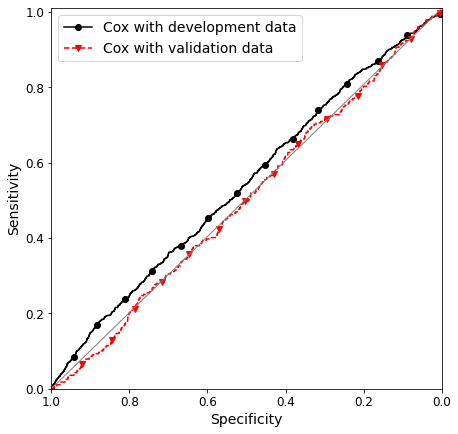

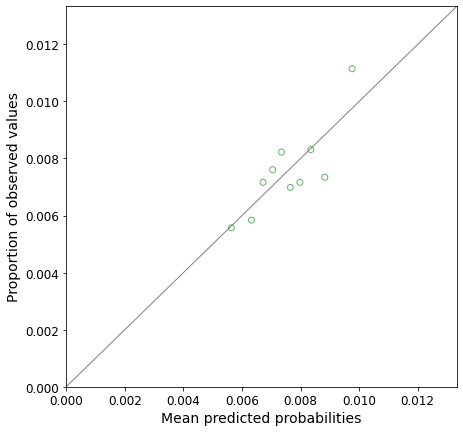

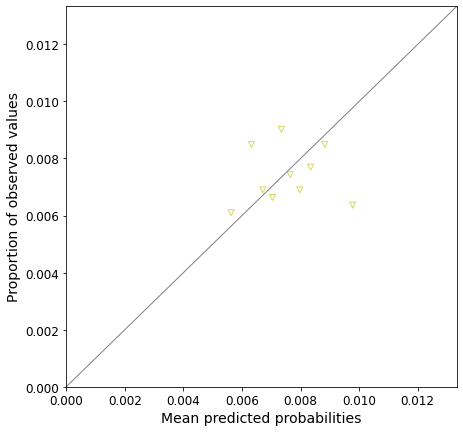

In [39]:
#data prep
data, data_cough_cold_no_abs_incdt_enc = cox_data_prep(data_cough_cold_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

#make summary table
make_summary_table('cough_cold', 'no_abs_incdt', data_cough_cold_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('cough_cold', 'no_abs_incdt', data_cough_cold_no_abs_incdt)

try:
    #build cox model 
    cph_cough_cold_no_abs_incdt, data_cough_cold_no_abs_incdt_train, data_cough_cold_no_abs_incdt_test = cox_model_build('cough_cold', 'no_abs_incdt', data_cough_cold_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_cough_cold_no_abs_incdt, '../output/hospitalisation_prediction_cough_cold/', 'betas_cph_cough_cold_no_abs_incdt.csv', data_cough_cold_no_abs_incdt_enc, data_cough_cold_no_abs_incdt, 'sum_betas_cph_cough_cold_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_cough_cold_no_abs_incdt, 'event_cough_cold_admitted', data_cough_cold_no_abs_incdt_train, data_cough_cold_no_abs_incdt_test, '../output/hospitalisation_prediction_cough_cold', 'roc_cph_cough_cold_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_cough_cold_no_abs_incdt, data_cough_cold_no_abs_incdt_train, 'event_cough_cold_admitted', data_cough_cold_no_abs_incdt_test, '../output/hospitalisation_prediction_cough_cold/', 'calibration_cph_cough_cold_no_abs_incdt_train.jpg', 'calibration_cph_cough_cold_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_cough_cold_no_abs_incdt, 'cough_cold', 'no_abs_incdt', data_cough_cold_no_abs_incdt_train, data_cough_cold_no_abs_incdt_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident cough_cold with antibiotics

<lifelines.CoxPHFitter: fitted with 12444 total observations, 12342 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 12444
number of events observed = 102
   partial log-likelihood = -941.28
         time fit was run = 2023-03-29 19:15:44 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.04       1.05       0.30            -0.55             0.64                 0.58                 1.89
CCI_cat[T.medium]                0.35       1.42       0.32            -0.27             0.97                 0.77                 2.64
CCI_cat[T.high]                 -0.03       0.97       0.40            -0.82             0.76                 0.44                 2.15
CCI_cat[T.very_high]            -0.12       0.89       0.37            -0.84             0.60                 0.43                 1.82
age_cat[T.25_34]                 0.19       1.21       0.35            -0.50             0.88                 0.61                 2.40
age_cat[T.35_44]                 0.05       1.05       0.36            -0.66             0.76                 0.52                 2.13
age_cat[T.45_54]                -0.50       0.60       0.42            -1.33             0.32                 0.26                 1.38
age_cat[T.55_64]                 0.03       1.03       0.37            -0.69             0.75                 0.50                 2.11
age_cat[T.65_74]                 0.22       1.24       0.34            -0.45             0.89                 0.63                 2.43
age_cat[T.75_more]              -0.58       0.56       0.42            -1.41             0.24                 0.24                 1.28
antibacterial_brit               0.09       1.09       0.07            -0.04             0.22                 0.96                 1.25
bmi_cat[T.obese]                -0.34       0.71       0.33            -1.00             0.31                 0.37                 1.37
bmi_cat[T.overweight]           -0.23       0.79       0.42            -1.05             0.59                 0.35                 1.80
bmi_cat[T.underweight]          -1.43       0.24       1.05            -3.48             0.62                 0.03                 1.86
bmi_cat[T.unknown]              -0.19       0.83       0.36            -0.89             0.51                 0.41                 1.66
ethnicity[T.unknown]             0.15       1.16       0.33            -0.49             0.79                 0.61                 2.21
ethnicity[T.white]               0.04       1.04       0.30            -0.55             0.62                 0.58                 1.86
flu_vaccine[T.yes]               0.06       1.06       0.32            -0.57             0.68                 0.56                 1.98
imd[T.medium]                    0.14       1.15       0.33            -0.50             0.78                 0.61                 2.18
imd[T.unaffluent]                0.34       1.40       0.31            -0.27             0.95                 0.76                 2.58
imd[T.unknown]                  -0.83       0.43       0.75            -2.29             0.63                 0.10                 1.88
imd[T.very_affluent]             0.16       1.17       0.32            -0.47             0.79                 0.62                 2.20
imd[T.very_unaffluent]          -0.08       0.93       0.34            -0.75             0.60                 0.47                 1.82
region[T.east_midlands]         -0.56       0.57       0.63            -1.79             0.67                 0.17                 1.96
region[T.london]                 0.75       2.12       0.

12771


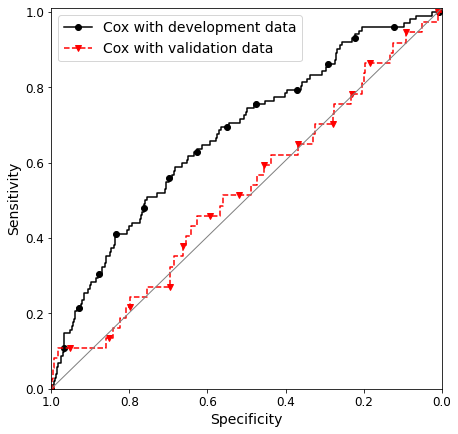

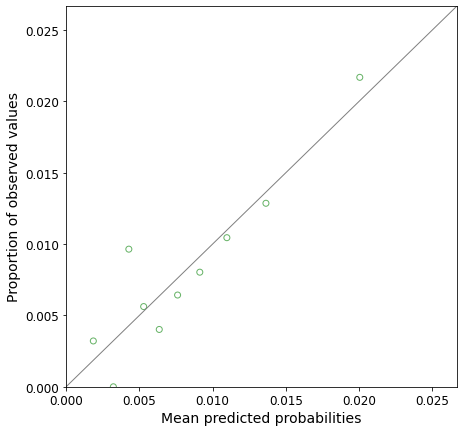

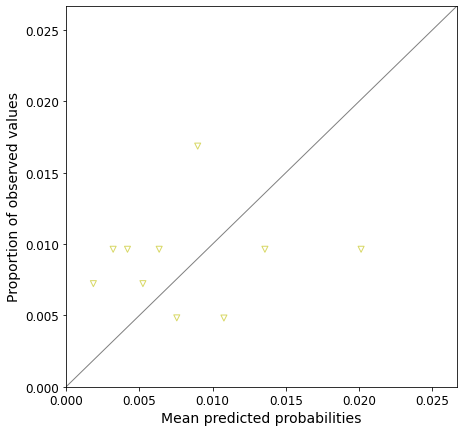

In [40]:
#data prep
data, data_cough_cold_abs_incdt_enc = cox_data_prep(data_cough_cold_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

#make summary table
make_summary_table('cough_cold', 'abs_incdt', data_cough_cold_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('cough_cold', 'abs_incdt', data_cough_cold_abs_incdt)

try:
    #build cox model 
    cph_cough_cold_abs_incdt, data_cough_cold_abs_incdt_train, data_cough_cold_abs_incdt_test = cox_model_build('cough_cold', 'abs_incdt', data_cough_cold_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_cough_cold_abs_incdt, '../output/hospitalisation_prediction_cough_cold/', 'betas_cph_cough_cold_abs_incdt.csv', data_cough_cold_abs_incdt_enc, data_cough_cold_abs_incdt, 'sum_betas_cph_cough_cold_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_cough_cold_abs_incdt, 'event_cough_cold_admitted', data_cough_cold_abs_incdt_train, data_cough_cold_abs_incdt_test, '../output/hospitalisation_prediction_cough_cold', 'roc_cph_cough_cold_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_cough_cold_abs_incdt, data_cough_cold_abs_incdt_train, 'event_cough_cold_admitted', data_cough_cold_abs_incdt_test, '../output/hospitalisation_prediction_cough_cold/', 'calibration_cph_cough_cold_abs_incdt_train.jpg', 'calibration_cph_cough_cold_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_cough_cold_abs_incdt, 'cough_cold', 'abs_incdt', data_cough_cold_abs_incdt_train, data_cough_cold_abs_incdt_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent cough_cold with no antibiotics

<lifelines.CoxPHFitter: fitted with 12626 total observations, 12532 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 12626
number of events observed = 94
   partial log-likelihood = -873.48
         time fit was run = 2023-03-29 19:15:47 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.23       0.79       0.29            -0.80             0.34                 0.45                 1.40
CCI_cat[T.medium]               -0.24       0.79       0.33            -0.87             0.40                 0.42                 1.49
CCI_cat[T.high]                 -0.30       0.74       0.41            -1.10             0.49                 0.33                 1.63
CCI_cat[T.very_high]            -0.24       0.79       0.35            -0.92             0.44                 0.40                 1.55
age_cat[T.25_34]                 0.58       1.78       0.42            -0.25             1.41                 0.78                 4.08
age_cat[T.35_44]                 0.30       1.35       0.44            -0.57             1.16                 0.57                 3.20
age_cat[T.45_54]                 0.60       1.83       0.42            -0.22             1.42                 0.81                 4.14
age_cat[T.55_64]                 0.32       1.37       0.44            -0.55             1.18                 0.58                 3.27
age_cat[T.65_74]                 0.58       1.79       0.42            -0.24             1.41                 0.78                 4.10
age_cat[T.75_more]               0.56       1.76       0.42            -0.26             1.39                 0.77                 4.02
antibacterial_brit               0.02       1.02       0.07            -0.12             0.16                 0.89                 1.18
bmi_cat[T.obese]                -0.32       0.72       0.35            -1.01             0.36                 0.37                 1.43
bmi_cat[T.overweight]           -0.35       0.70       0.45            -1.23             0.53                 0.29                 1.70
bmi_cat[T.underweight]          -0.71       0.49       0.78            -2.23             0.81                 0.11                 2.25
bmi_cat[T.unknown]              -0.27       0.77       0.37            -1.00             0.47                 0.37                 1.60
ethnicity[T.unknown]             0.30       1.35       0.34            -0.36             0.96                 0.70                 2.61
ethnicity[T.white]              -0.00       1.00       0.31            -0.61             0.61                 0.54                 1.83
flu_vaccine[T.yes]               0.57       1.77       0.28             0.02             1.13                 1.02                 3.09
imd[T.medium]                   -0.24       0.79       0.30            -0.83             0.35                 0.44                 1.42
imd[T.unaffluent]               -0.58       0.56       0.33            -1.24             0.07                 0.29                 1.08
imd[T.unknown]                  -1.17       0.31       0.74            -2.61             0.27                 0.07                 1.31
imd[T.very_affluent]            -0.59       0.56       0.33            -1.24             0.07                 0.29                 1.07
imd[T.very_unaffluent]          -0.29       0.74       0.30            -0.89             0.30                 0.41                 1.35
region[T.east_midlands]         -1.00       0.37       0.58            -2.14             0.15                 0.12                 1.16
region[T.london]                -0.03       0.97       0.3

12787


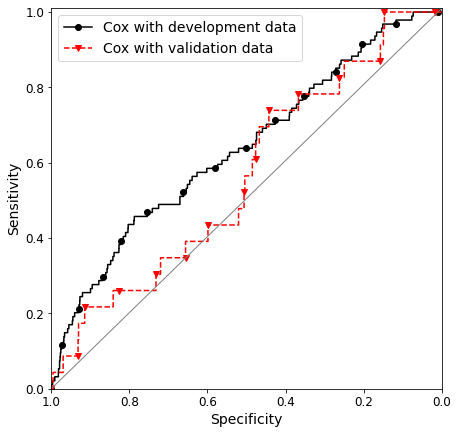

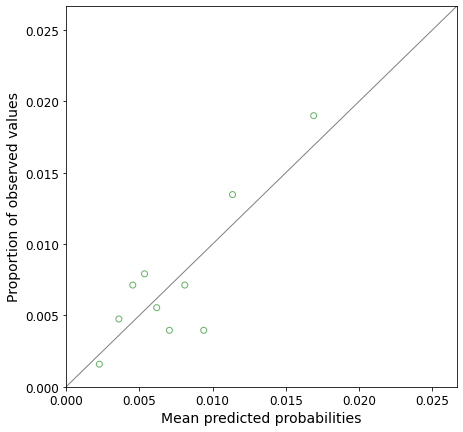

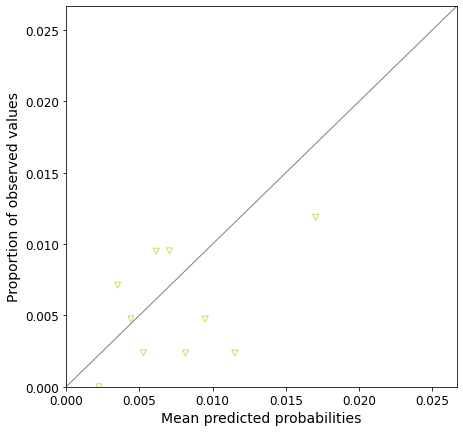

In [41]:
#data prep
data, data_cough_cold_no_abs_prevl_enc = cox_data_prep(data_cough_cold_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

#make summary table
make_summary_table('cough_cold', 'no_abs_prevl', data_cough_cold_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('cough_cold', 'no_abs_prevl', data_cough_cold_no_abs_prevl)

try:
    #build cox model 
    cph_cough_cold_no_abs_prevl, data_cough_cold_no_abs_prevl_train, data_cough_cold_no_abs_prevl_test = cox_model_build('cough_cold', 'no_abs_prevl', data_cough_cold_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_cough_cold_no_abs_prevl, '../output/hospitalisation_prediction_cough_cold/', 'betas_cph_cough_cold_no_abs_prevl.csv', data_cough_cold_no_abs_prevl_enc, data_cough_cold_no_abs_prevl, 'sum_betas_cph_cough_cold_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_cough_cold_no_abs_prevl, 'event_cough_cold_admitted', data_cough_cold_no_abs_prevl_train, data_cough_cold_no_abs_prevl_test, '../output/hospitalisation_prediction_cough_cold', 'roc_cph_cough_cold_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_cough_cold_no_abs_prevl, data_cough_cold_no_abs_prevl_train, 'event_cough_cold_admitted', data_cough_cold_no_abs_prevl_test, '../output/hospitalisation_prediction_cough_cold/', 'calibration_cph_cough_cold_no_abs_prevl_train.jpg', 'calibration_cph_cough_cold_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_cough_cold_no_abs_prevl, 'cough_cold', 'no_abs_prevl', data_cough_cold_no_abs_prevl_train, data_cough_cold_no_abs_prevl_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent cough_cold with antibiotics

<lifelines.CoxPHFitter: fitted with 1410 total observations, 1402 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 1410
number of events observed = 8
   partial log-likelihood = -41.53
         time fit was run = 2023-03-29 19:15:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.36       0.26       0.92            -3.16             0.45                 0.04                 1.56
CCI_cat[T.medium]               -1.78       0.17       1.25            -4.22             0.66                 0.01                 1.94
CCI_cat[T.high]                -18.81       0.00    8703.13        -17076.63         17039.01                 0.00                  inf
CCI_cat[T.very_high]            -1.56       0.21       1.23            -3.97             0.86                 0.02                 2.37
age_cat[T.25_34]                18.28   8.69e+07    7966.48        -15595.74         15632.30                 0.00                  inf
age_cat[T.35_44]                19.00   1.78e+08    7966.48        -15595.03         15633.02                 0.00                  inf
age_cat[T.45_54]                18.41   9.88e+07    7966.48        -15595.62         15632.43                 0.00                  inf
age_cat[T.55_64]                17.79   5.33e+07    7966.48        -15596.23         15631.81                 0.00                  inf
age_cat[T.65_74]                19.19   2.16e+08    7966.48        -15594.83         15633.22                 0.00                  inf
age_cat[T.75_more]              18.33   9.16e+07    7966.48        -15595.69         15632.36                 0.00                  inf
antibacterial_brit               0.25       1.28       0.28            -0.29             0.79                 0.75                 2.21
bmi_cat[T.obese]                -0.88       0.42       1.28            -3.39             1.64                 0.03                 5.14
bmi_cat[T.overweight]          -18.58       0.00    9967.21        -19553.94         19516.79                 0.00                  inf
bmi_cat[T.underweight]         -18.62       0.00   13671.58        -26814.42         26777.17                 0.00                  inf
bmi_cat[T.unknown]               0.46       1.58       1.19            -1.86             2.78                 0.15                16.16
ethnicity[T.unknown]            18.50   1.08e+08    6732.63        -13177.22         13214.21                 0.00                  inf
ethnicity[T.white]              18.39   9.71e+07    6732.63        -13177.32         13214.11                 0.00                  inf
flu_vaccine[T.yes]               0.45       1.57       1.19            -1.88             2.78                 0.15                16.13
imd[T.medium]                   -0.68       0.50       1.33            -3.30             1.93                 0.04                 6.86
imd[T.unaffluent]                0.80       2.23       1.03            -1.22             2.82                 0.30                16.85
imd[T.unknown]                 -18.24       0.00   13463.78        -26406.77         26370.29                 0.00                  inf
imd[T.very_affluent]            -0.65       0.52       1.31            -3.22             1.92                 0.04                 6.83
imd[T.very_unaffluent]          -0.90       0.41       1.33            -3.51             1.72                 0.03                 5.57
region[T.east_midlands]         -0.21       0.81       1.56            -3.26             2.85                 0.04                17.23
region[T.london]                 0.08       1.08       1.24    

12999


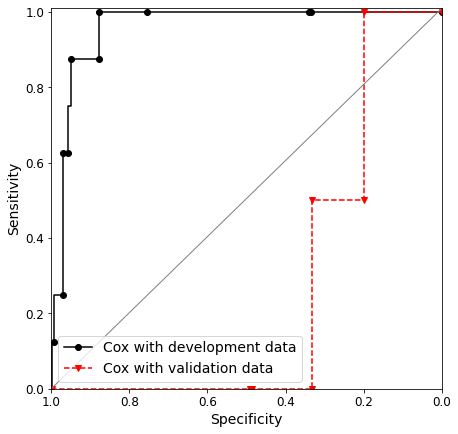

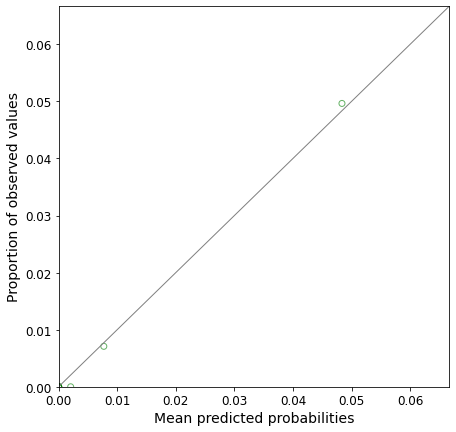

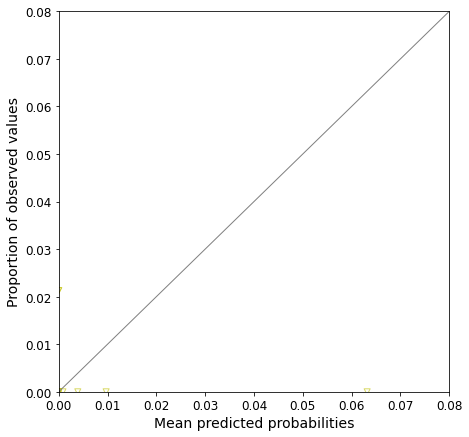

In [42]:
#data prep
data, data_cough_cold_abs_prevl_enc = cox_data_prep(data_cough_cold_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

#make summary table
make_summary_table('cough_cold', 'abs_prevl', data_cough_cold_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('cough_cold', 'abs_prevl', data_cough_cold_abs_prevl)

try:
    #build cox model 
    cph_cough_cold_abs_prevl, data_cough_cold_abs_prevl_train, data_cough_cold_abs_prevl_test = cox_model_build('cough_cold', 'abs_prevl', data_cough_cold_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_cough_cold_abs_prevl, '../output/hospitalisation_prediction_cough_cold/', 'betas_cph_cough_cold_abs_prevl.csv', data_cough_cold_abs_prevl_enc, data_cough_cold_abs_prevl, 'sum_betas_cph_cough_cold_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_cough_cold_abs_prevl, 'event_cough_cold_admitted', data_cough_cold_abs_prevl_train, data_cough_cold_abs_prevl_test, '../output/hospitalisation_prediction_cough_cold', 'roc_cph_cough_cold_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_cough_cold_abs_prevl, data_cough_cold_abs_prevl_train, 'event_cough_cold_admitted', data_cough_cold_abs_prevl_test, '../output/hospitalisation_prediction_cough_cold/', 'calibration_cph_cough_cold_abs_prevl_train.jpg', 'calibration_cph_cough_cold_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_cough_cold_abs_prevl, 'cough_cold', 'abs_prevl', data_cough_cold_abs_prevl_train, data_cough_cold_abs_prevl_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident cough_cold

In [83]:
#build cox model with an additional binary variable for antibiotics
def cox_model_abs_build_2(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + cough_cold_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics 
    #predict cumulative hazard in day 30 in train dataset
    prob_pred_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_train.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_train['bins'] = pd.qcut(prob_pred_train['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_train = pd.merge(prob_pred_train, data_train[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_train = prob_pred_train.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_train.columns = ['bins', 'pred_mean_train', 'pred_sum', 'pred_count', 'ab_prob_mean_train', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin = prob_pred_groupby_bin_train[['pred_mean_train', 'ab_prob_mean_train']]

    #predict cumulative hazard in day 30 in test dataset
    prob_pred_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T
    prob_pred_test.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_test['bins'] = pd.qcut(prob_pred_test['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_test = pd.merge(prob_pred_test, data_test[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_test = prob_pred_test.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_test.columns = ['bins', 'pred_mean_test', 'pred_sum', 'pred_count', 'ab_prob_mean_test', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin[['pred_mean_test', 'ab_prob_mean_test']] = prob_pred_groupby_bin_test[['pred_mean_test', 'ab_prob_mean_test']]

    #save binned prob_pred, train and test combined
    prob_pred_groupby_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_groupby_bin_'+infection+'_'+infection_type+'.csv', index=False)

    return cph, data_train, data_test, prob_pred_train, prob_pred_groupby_bin_train, prob_pred_groupby_bin

In [ ]:
cph, data_train, data_test, prob_pred_train, prob_pred_groupby_bin_train, prob_pred_groupby_bin = cox_model_abs_build_2('cough_cold', 'incdt', data_cough_cold_incdt)

In [87]:
prob_pred_train

,pred,bins,cough_cold_ab_date
222458,0.005148,"(0.0017100000000000001, 0.0056]",0
306260,0.006479,"(0.00615, 0.00658]",0
215086,0.008539,"(0.0082, 0.00877]",1
169600,0.006305,"(0.00615, 0.00658]",1
197665,0.010212,"(0.00961, 0.0158]",1
...,...,...,...
258184,0.007731,"(0.00736, 0.00776]",0
223078,0.007649,"(0.00736, 0.00776]",0
284030,0.005811,"(0.0056, 0.00615]",1
316036,0.008131,"(0.00776, 0.0082]",1


In [88]:
prob_pred_groupby_bin_train

,bins,pred_mean_train,pred_sum,pred_count,ab_prob_mean_train,ab_prob_sum,ab_prob_count
0,"(0.0017100000000000001, 0.0056]",0.005057,63.464553,12550,0.049243,618,12550
1,"(0.0056, 0.00615]",0.005892,73.950468,12550,0.061912,777,12550
2,"(0.00615, 0.00658]",0.006372,79.964538,12550,0.069880,877,12550
3,"(0.00658, 0.00697]",0.006776,85.038288,12549,0.080644,1012,12549
4,"(0.00697, 0.00736]",0.007164,89.904069,12550,0.092032,1155,12550
5,"(0.00736, 0.00776]",0.007553,94.790734,12550,0.100876,1266,12550
6,"(0.00776, 0.0082]",0.007975,100.091157,12550,0.106693,1339,12550
7,"(0.0082, 0.00877]",0.008475,106.350684,12549,0.121922,1530,12549
8,"(0.00877, 0.00961]",0.009156,114.901710,12550,0.135618,1702,12550
9,"(0.00961, 0.0158]",0.010604,133.075857,12550,0.179283,2250,12550


In [89]:
prob_pred_groupby_bin

,pred_mean_train,ab_prob_mean_train,pred_mean_test,ab_prob_mean_test
0,0.005057,0.049243,0.005062,0.050908
1,0.005892,0.061912,0.005891,0.063591
2,0.006372,0.069880,0.006376,0.070284
3,0.006776,0.080644,0.006772,0.070045
4,0.007164,0.092032,0.007155,0.089866
5,0.007553,0.100876,0.007543,0.084628
6,0.007975,0.106693,0.007968,0.104231
7,0.008475,0.121922,0.008474,0.126225
8,0.009156,0.135618,0.009162,0.137700
9,0.010604,0.179283,0.010591,0.174713


In [43]:
#data prep
data, data_cough_cold_incdt_enc = cox_data_prep(data_cough_cold_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

#make summary tables from preped data
make_summary_table('cough_cold', 'incdt', data_cough_cold_incdt_enc)
make_summary_table_hosped('cough_cold', 'incdt', data_cough_cold_incdt)

try:
    cph_cough_cold_incdt, data_cough_cold_incdt_train, data_cough_cold_incdt_test = cox_model_abs_build('cough_cold', 'incdt', data_cough_cold_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_cough_cold_incdt, 'cough_cold', 'incdt', data_cough_cold_incdt_train, data_cough_cold_incdt_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 125498 total observations, 124560 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 125498
number of events observed = 938
   partial log-likelihood = -10988.00
         time fit was run = 2023-03-29 19:15:52 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.15       1.16       0.10            -0.05             0.35                 0.95                 1.42
CCI_cat[T.medium]                0.21       1.24       0.11            -0.00             0.43                 1.00                 1.54
CCI_cat[T.high]                  0.08       1.08       0.13            -0.18             0.34                 0.83                 1.41
CCI_cat[T.very_high]             0.20       1.23       0.12            -0.02             0.43                 0.98                 1.54
age_cat[T.25_34]                 0.08       1.08       0.12            -0.16             0.32                 0.85                 1.38
age_cat[T.35_44]                 0.01       1.01       0.12            -0.23             0.26                 0.79                 1.29
age_cat[T.45_54]                 0.13       1.14       0.12            -0.11             0.37                 0.90                 1.44
age_cat[T.55_64]                 0.07       1.07       0.12            -0.17             0.31                 0.84                 1.37
age_cat[T.65_74]                 0.08       1.08       0.12            -0.16             0.32                 0.85                 1.38
age_cat[T.75_more]              -0.04       0.96       0.13            -0.29             0.20                 0.75                 1.23
antibacterial_brit               0.02       1.02       0.02            -0.03             0.06                 0.97                 1.06
bmi_cat[T.obese]                -0.13       0.88       0.12            -0.36             0.11                 0.70                 1.11
bmi_cat[T.overweight]           -0.09       0.91       0.15            -0.38             0.20                 0.68                 1.22
bmi_cat[T.underweight]          -0.14       0.87       0.22            -0.57             0.29                 0.57                 1.34
bmi_cat[T.unknown]               0.04       1.04       0.13            -0.21             0.29                 0.81                 1.33
cough_cold_ab_date               0.09       1.09       0.11            -0.12             0.29                 0.89                 1.34
ethnicity[T.unknown]             0.16       1.18       0.11            -0.05             0.38                 0.95                 1.46
ethnicity[T.white]               0.13       1.14       0.10            -0.07             0.32                 0.93                 1.38
flu_vaccine[T.yes]              -0.10       0.91       0.11            -0.32             0.13                 0.73                 1.13
imd[T.medium]                   -0.02       0.98       0.10            -0.22             0.19                 0.80                 1.21
imd[T.unaffluent]               -0.04       0.96       0.10            -0.24             0.16                 0.78                 1.18
imd[T.unknown]                  -0.33       0.72       0.18            -0.69             0.03                 0.50                 1.03
imd[T.very_affluent]            -0.04       0.96       0.10            -0.25             0.16                 0.78                 1.18
imd[T.very_unaffluent]          -0.05       0.95       0.11            -0.25             0.16                 0.78                 1.17
region[T.east_midlands]         -0.00       1.00    

13048


### 5-6- hospital admission related to prevalent cough_cold

In [44]:
#data prep
data, data_cough_cold_prevl_enc = cox_data_prep(data_cough_cold_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

#make summary tables from preped data
make_summary_table('cough_cold', 'prevl', data_cough_cold_prevl_enc)
make_summary_table_hosped('cough_cold', 'prevl', data_cough_cold_prevl)

try:
    cph_cough_cold_prevl, data_cough_cold_prevl_train, data_cough_cold_prevl_test = cox_model_abs_build('cough_cold', 'prevl', data_cough_cold_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_cold_prevl, 'cough_cold', 'prevl', data_cough_cold_prevl_train, data_cough_cold_prevl_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 14036 total observations, 13945 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 14036
number of events observed = 91
   partial log-likelihood = -846.16
         time fit was run = 2023-03-29 19:15:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.35       0.71       0.29            -0.91             0.22                 0.40                 1.25
CCI_cat[T.medium]               -0.37       0.69       0.33            -1.00             0.27                 0.37                 1.31
CCI_cat[T.high]                 -0.45       0.64       0.42            -1.27             0.37                 0.28                 1.45
CCI_cat[T.very_high]            -0.28       0.76       0.34            -0.95             0.39                 0.39                 1.48
age_cat[T.25_34]                 0.61       1.84       0.48            -0.33             1.54                 0.72                 4.67
age_cat[T.35_44]                 0.67       1.96       0.46            -0.23             1.58                 0.79                 4.87
age_cat[T.45_54]                 0.74       2.11       0.46            -0.16             1.65                 0.85                 5.23
age_cat[T.55_64]                 0.55       1.74       0.48            -0.38             1.49                 0.68                 4.42
age_cat[T.65_74]                 0.96       2.61       0.45             0.08             1.84                 1.08                 6.30
age_cat[T.75_more]               0.79       2.21       0.46            -0.11             1.69                 0.90                 5.43
antibacterial_brit               0.02       1.02       0.07            -0.12             0.17                 0.89                 1.18
bmi_cat[T.obese]                -0.47       0.62       0.34            -1.13             0.19                 0.32                 1.21
bmi_cat[T.overweight]           -0.93       0.39       0.51            -1.93             0.06                 0.15                 1.06
bmi_cat[T.underweight]          -1.54       0.21       1.05            -3.59             0.51                 0.03                 1.66
bmi_cat[T.unknown]              -0.24       0.79       0.36            -0.94             0.46                 0.39                 1.58
cough_cold_ab_date              -0.68       0.51       0.46            -1.58             0.22                 0.21                 1.25
ethnicity[T.unknown]             0.59       1.80       0.37            -0.13             1.31                 0.88                 3.70
ethnicity[T.white]               0.22       1.25       0.35            -0.45             0.90                 0.64                 2.46
flu_vaccine[T.yes]               0.50       1.65       0.29            -0.07             1.07                 0.93                 2.92
imd[T.medium]                   -0.47       0.63       0.31            -1.08             0.15                 0.34                 1.16
imd[T.unaffluent]               -0.71       0.49       0.34            -1.38            -0.05                 0.25                 0.96
imd[T.unknown]                  -0.84       0.43       0.61            -2.03             0.36                 0.13                 1.43
imd[T.very_affluent]            -0.65       0.52       0.33            -1.30             0.00                 0.27                 1.00
imd[T.very_unaffluent]          -0.39       0.68       0.31            -0.99             0.21                 0.37                 1.23
region[T.east_midlands]         -0.69       0.50       0.5

13058


### 5-7- hospital admission related to incident cough_cold with prescribed antibiotics categories

In [45]:
#data prep
data, data_cough_cold_incdt_abs_enc = cox_data_prep(data_cough_cold_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_abs, data_cough_cold_incdt_abs_train, data_cough_cold_incdt_abs_test = cox_model_ab_type_build('cough_cold', 'incdt_ab_type', data_cough_cold_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_cough_cold_incdt_abs, 'cough_cold', 'incdt_abs', data_cough_cold_incdt_abs_train, data_cough_cold_incdt_abs_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 125498 total observations, 124560 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 125498
number of events observed = 938
   partial log-likelihood = -10985.91
         time fit was run = 2023-03-29 19:15:59 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.15       1.16       0.10            -0.05             0.35                 0.95                 1.42
CCI_cat[T.medium]                0.21       1.24       0.11            -0.00             0.43                 1.00                 1.54
CCI_cat[T.high]                  0.08       1.08       0.13            -0.18             0.34                 0.83                 1.41
CCI_cat[T.very_high]             0.21       1.23       0.12            -0.02             0.43                 0.98                 1.54
ab_type_cat[T.Doxycycline]       1.12       3.08       1.00            -0.84             3.08                 0.43                21.85
ab_type_cat[T.no]                1.06       2.88       0.71            -0.33             2.44                 0.72                11.52
ab_type_cat[T.other]             1.19       3.29       0.71            -0.21             2.59                 0.81                13.33
age_cat[T.25_34]                 0.08       1.08       0.12            -0.16             0.32                 0.85                 1.38
age_cat[T.35_44]                 0.01       1.01       0.12            -0.23             0.26                 0.79                 1.29
age_cat[T.45_54]                 0.13       1.14       0.12            -0.11             0.37                 0.90                 1.44
age_cat[T.55_64]                 0.07       1.07       0.12            -0.17             0.31                 0.84                 1.37
age_cat[T.65_74]                 0.08       1.08       0.12            -0.16             0.32                 0.85                 1.38
age_cat[T.75_more]              -0.04       0.96       0.13            -0.29             0.21                 0.75                 1.23
antibacterial_brit               0.02       1.02       0.02            -0.03             0.06                 0.97                 1.06
bmi_cat[T.obese]                -0.13       0.88       0.12            -0.36             0.11                 0.70                 1.11
bmi_cat[T.overweight]           -0.09       0.91       0.15            -0.38             0.20                 0.68                 1.22
bmi_cat[T.underweight]          -0.14       0.87       0.22            -0.57             0.29                 0.57                 1.33
bmi_cat[T.unknown]               0.04       1.04       0.13            -0.21             0.28                 0.81                 1.33
ethnicity[T.unknown]             0.16       1.18       0.11            -0.05             0.38                 0.95                 1.46
ethnicity[T.white]               0.13       1.14       0.10            -0.07             0.32                 0.94                 1.38
flu_vaccine[T.yes]              -0.09       0.91       0.11            -0.32             0.13                 0.73                 1.14
imd[T.medium]                   -0.02       0.98       0.10            -0.22             0.19                 0.80                 1.21
imd[T.unaffluent]               -0.04       0.96       0.10            -0.25             0.16                 0.78                 1.18
imd[T.unknown]                  -0.33       0.72       0.18            -0.69             0.03                 0.50                 1.03
imd[T.very_affluent]            -0.04       0.96    

13608


### 5-8- hospital admission related to prevalent cough_cold with prescribed antibiotics categories

In [46]:
#data prep
data, data_cough_cold_prevl_abs_enc = cox_data_prep(data_cough_cold_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_abs, data_cough_cold_prevl_abs_train, data_cough_cold_prevl_abs_test = cox_model_ab_type_build('cough_cold', 'prevl_ab_type', data_cough_cold_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_cough_cold_prevl_abs, 'cough_cold', 'prevl_abs', data_cough_cold_prevl_abs_train, data_cough_cold_prevl_abs_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 14036 total observations, 13945 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 14036
number of events observed = 91
   partial log-likelihood = -845.77
         time fit was run = 2023-03-29 19:16:04 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.35       0.71       0.29            -0.91             0.22                 0.40                 1.25
CCI_cat[T.medium]               -0.37       0.69       0.33            -1.00             0.27                 0.37                 1.31
CCI_cat[T.high]                 -0.45       0.64       0.42            -1.27             0.37                 0.28                 1.45
CCI_cat[T.very_high]            -0.28       0.75       0.34            -0.95             0.39                 0.39                 1.48
ab_type_cat[T.Doxycycline]       0.05       1.05    4502.10         -8823.90          8823.99                 0.00                  inf
ab_type_cat[T.no]               14.95   3.11e+06    2370.26         -4630.68          4660.58                 0.00                  inf
ab_type_cat[T.other]            14.35   1.70e+06    2370.26         -4631.28          4659.98                 0.00                  inf
age_cat[T.25_34]                 0.60       1.83       0.48            -0.33             1.54                 0.72                 4.66
age_cat[T.35_44]                 0.67       1.96       0.46            -0.24             1.58                 0.79                 4.86
age_cat[T.45_54]                 0.74       2.10       0.46            -0.17             1.65                 0.85                 5.22
age_cat[T.55_64]                 0.55       1.74       0.48            -0.38             1.48                 0.68                 4.41
age_cat[T.65_74]                 0.95       2.60       0.45             0.07             1.84                 1.07                 6.27
age_cat[T.75_more]               0.79       2.21       0.46            -0.11             1.69                 0.90                 5.43
antibacterial_brit               0.02       1.02       0.07            -0.12             0.17                 0.89                 1.18
bmi_cat[T.obese]                -0.47       0.62       0.34            -1.13             0.19                 0.32                 1.21
bmi_cat[T.overweight]           -0.93       0.39       0.51            -1.93             0.06                 0.15                 1.06
bmi_cat[T.underweight]          -1.55       0.21       1.05            -3.60             0.50                 0.03                 1.65
bmi_cat[T.unknown]              -0.24       0.79       0.36            -0.94             0.46                 0.39                 1.58
ethnicity[T.unknown]             0.59       1.80       0.37            -0.13             1.31                 0.87                 3.69
ethnicity[T.white]               0.22       1.25       0.35            -0.46             0.90                 0.63                 2.46
flu_vaccine[T.yes]               0.50       1.64       0.29            -0.07             1.07                 0.93                 2.91
imd[T.medium]                   -0.47       0.63       0.31            -1.08             0.15                 0.34                 1.16
imd[T.unaffluent]               -0.71       0.49       0.34            -1.38            -0.05                 0.25                 0.96
imd[T.unknown]                  -0.84       0.43       0.61            -2.03             0.36                 0.13                 1.43
imd[T.very_affluent]            -0.65       0.52       0.3

13647


### 5-9- stratified by sex
#### 5-9-1- incident males

In [47]:
#data prep
data, data_cough_cold_incdt_males_enc = cox_data_prep(data_cough_cold_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_males, data_cough_cold_incdt_males_train, data_cough_cold_incdt_males_test = cox_model_strat_sex_build('cough_cold', 'incdt_males', data_cough_cold_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_cough_cold_incdt_males, 'cough_cold', 'incdt_males', data_cough_cold_incdt_males_train, data_cough_cold_incdt_males_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 61092 total observations, 60623 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 61092
number of events observed = 469
   partial log-likelihood = -5143.84
         time fit was run = 2023-03-29 19:16:06 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.29       1.34       0.15            -0.00             0.58                 1.00                 1.79
CCI_cat[T.medium]                0.33       1.39       0.16             0.02             0.65                 1.02                 1.91
CCI_cat[T.high]                  0.37       1.45       0.18             0.02             0.73                 1.02                 2.08
CCI_cat[T.very_high]             0.06       1.06       0.18            -0.29             0.41                 0.75                 1.50
age_cat[T.25_34]                -0.13       0.88       0.17            -0.46             0.20                 0.63                 1.23
age_cat[T.35_44]                -0.07       0.93       0.17            -0.40             0.26                 0.67                 1.30
age_cat[T.45_54]                 0.01       1.01       0.16            -0.32             0.33                 0.73                 1.39
age_cat[T.55_64]                -0.25       0.78       0.18            -0.59             0.10                 0.55                 1.10
age_cat[T.65_74]                -0.05       0.95       0.17            -0.38             0.27                 0.68                 1.31
age_cat[T.75_more]              -0.26       0.77       0.17            -0.60             0.08                 0.55                 1.08
antibacterial_brit              -0.05       0.95       0.03            -0.11             0.02                 0.89                 1.02
bmi_cat[T.obese]                -0.14       0.87       0.17            -0.48             0.19                 0.62                 1.21
bmi_cat[T.overweight]           -0.05       0.95       0.21            -0.46             0.36                 0.63                 1.43
bmi_cat[T.underweight]           0.09       1.10       0.29            -0.47             0.66                 0.62                 1.94
bmi_cat[T.unknown]               0.10       1.10       0.18            -0.25             0.45                 0.78                 1.57
cough_cold_ab_date               0.06       1.06       0.15            -0.23             0.36                 0.79                 1.43
ethnicity[T.unknown]             0.18       1.20       0.16            -0.13             0.49                 0.87                 1.63
ethnicity[T.white]               0.22       1.25       0.14            -0.06             0.50                 0.94                 1.65
flu_vaccine[T.yes]               0.14       1.15       0.15            -0.14             0.43                 0.87                 1.54
imd[T.medium]                   -0.14       0.87       0.15            -0.44             0.16                 0.65                 1.18
imd[T.unaffluent]               -0.08       0.92       0.15            -0.38             0.21                 0.68                 1.24
imd[T.unknown]                  -0.11       0.90       0.24            -0.58             0.36                 0.56                 1.43
imd[T.very_affluent]             0.02       1.02       0.15            -0.27             0.31                 0.77                 1.37
imd[T.very_unaffluent]           0.10       1.11       0.15            -0.18             0.39                 0.83                 1.48
region[T.east_midlands]         -0.02       0.98       0

12775


#### 5-9-2- incident females

In [48]:
#data prep
data, data_cough_cold_incdt_females_enc = cox_data_prep(data_cough_cold_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_females, data_cough_cold_incdt_females_train, data_cough_cold_incdt_females_test = cox_model_strat_sex_build('cough_cold', 'incdt_females', data_cough_cold_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_cold_incdt_females, 'cough_cold', 'incdt_females', data_cough_cold_incdt_females_train, data_cough_cold_incdt_females_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 64406 total observations, 63923 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 64406
number of events observed = 483
   partial log-likelihood = -5333.12
         time fit was run = 2023-03-29 19:16:08 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.10       1.11       0.14            -0.17             0.38                 0.85                 1.46
CCI_cat[T.medium]                0.12       1.13       0.15            -0.18             0.42                 0.83                 1.52
CCI_cat[T.high]                  0.01       1.01       0.19            -0.36             0.37                 0.70                 1.45
CCI_cat[T.very_high]             0.16       1.17       0.16            -0.15             0.47                 0.86                 1.60
age_cat[T.25_34]                 0.08       1.08       0.17            -0.26             0.41                 0.77                 1.51
age_cat[T.35_44]                -0.03       0.97       0.17            -0.37             0.31                 0.69                 1.37
age_cat[T.45_54]                -0.14       0.87       0.18            -0.49             0.22                 0.61                 1.24
age_cat[T.55_64]                 0.18       1.19       0.17            -0.15             0.51                 0.86                 1.66
age_cat[T.65_74]                 0.09       1.09       0.17            -0.25             0.42                 0.78                 1.53
age_cat[T.75_more]               0.09       1.10       0.17            -0.24             0.43                 0.79                 1.53
antibacterial_brit               0.02       1.02       0.03            -0.04             0.09                 0.96                 1.09
bmi_cat[T.obese]                -0.23       0.79       0.16            -0.54             0.08                 0.58                 1.08
bmi_cat[T.overweight]           -0.23       0.79       0.20            -0.62             0.15                 0.54                 1.17
bmi_cat[T.underweight]          -0.23       0.79       0.30            -0.81             0.34                 0.44                 1.41
bmi_cat[T.unknown]              -0.19       0.83       0.17            -0.52             0.14                 0.59                 1.15
cough_cold_ab_date               0.03       1.03       0.15            -0.27             0.32                 0.76                 1.38
ethnicity[T.unknown]             0.00       1.00       0.15            -0.30             0.30                 0.74                 1.35
ethnicity[T.white]               0.06       1.06       0.13            -0.21             0.32                 0.81                 1.38
flu_vaccine[T.yes]              -0.26       0.77       0.17            -0.60             0.07                 0.55                 1.08
imd[T.medium]                    0.06       1.06       0.14            -0.23             0.34                 0.80                 1.40
imd[T.unaffluent]                0.06       1.06       0.14            -0.23             0.34                 0.80                 1.40
imd[T.unknown]                  -0.47       0.63       0.28            -1.02             0.08                 0.36                 1.08
imd[T.very_affluent]            -0.02       0.98       0.15            -0.30             0.27                 0.74                 1.31
imd[T.very_unaffluent]          -0.06       0.94       0.15            -0.36             0.23                 0.70                 1.26
region[T.east_midlands]         -0.31       0.73       0

12794


#### 5-9-3- prevalent males

In [49]:
#data prep
data, data_cough_cold_prevl_males_enc = cox_data_prep(data_cough_cold_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_males, data_cough_cold_prevl_males_train, data_cough_cold_prevl_males_test = cox_model_strat_sex_build('cough_cold', 'prevl_males', data_cough_cold_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cox_output(cph_cough_cold_prevl_males, 'cough_cold', 'prevl_males', data_cough_cold_prevl_males_train, data_cough_cold_prevl_males_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6812 total observations, 6757 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 6812
number of events observed = 55
   partial log-likelihood = -464.11
         time fit was run = 2023-03-29 19:16:10 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.29       0.74       0.38            -1.05             0.46                 0.35                 1.58
CCI_cat[T.medium]               -0.41       0.67       0.44            -1.27             0.45                 0.28                 1.57
CCI_cat[T.high]                 -0.11       0.89       0.51            -1.11             0.89                 0.33                 2.43
CCI_cat[T.very_high]            -0.09       0.92       0.44            -0.95             0.77                 0.39                 2.16
age_cat[T.25_34]                 0.70       2.00       0.55            -0.38             1.77                 0.68                 5.88
age_cat[T.35_44]                -0.02       0.98       0.63            -1.26             1.22                 0.28                 3.40
age_cat[T.45_54]                 0.64       1.91       0.55            -0.43             1.72                 0.65                 5.61
age_cat[T.55_64]                 0.24       1.27       0.61            -0.95             1.43                 0.39                 4.18
age_cat[T.65_74]                 0.95       2.57       0.53            -0.10             1.99                 0.90                 7.33
age_cat[T.75_more]               0.35       1.42       0.59            -0.80             1.50                 0.45                 4.50
antibacterial_brit               0.05       1.05       0.09            -0.13             0.23                 0.87                 1.26
bmi_cat[T.obese]                 0.88       2.42       0.73            -0.55             2.31                 0.58                10.12
bmi_cat[T.overweight]            0.92       2.52       0.80            -0.65             2.50                 0.52                12.17
bmi_cat[T.underweight]           0.72       2.05       1.00            -1.25             2.68                 0.29                14.63
bmi_cat[T.unknown]               0.70       2.02       0.76            -0.79             2.19                 0.45                 8.95
cough_cold_ab_date              -0.67       0.51       0.60            -1.83             0.50                 0.16                 1.65
ethnicity[T.unknown]             0.25       1.28       0.49            -0.71             1.21                 0.49                 3.35
ethnicity[T.white]               0.31       1.36       0.44            -0.56             1.18                 0.57                 3.25
flu_vaccine[T.yes]               0.52       1.69       0.39            -0.23             1.28                 0.79                 3.59
imd[T.medium]                    0.14       1.15       0.45            -0.75             1.02                 0.47                 2.78
imd[T.unaffluent]                0.16       1.17       0.45            -0.73             1.04                 0.48                 2.84
imd[T.unknown]                   0.16       1.17       0.67            -1.15             1.47                 0.32                 4.35
imd[T.very_affluent]             0.51       1.67       0.42            -0.32             1.34                 0.73                 3.83
imd[T.very_unaffluent]          -0.44       0.65       0.53            -1.47             0.60                 0.23                 1.82
region[T.east_midlands]        -16.77       0.00    1987.77  

12782


#### 5-9-4- prevalent females

In [50]:
try:
    #data prep
    data, data_cough_cold_prevl_females_enc = cox_data_prep(data_cough_cold_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

    #cox model
    cph_cough_cold_prevl_females, data_cough_cold_prevl_females_train, data_cough_cold_prevl_females_test = cox_model_strat_sex_build('cough_cold', 'prevl_females', data_cough_cold_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_cough_cold_prevl_females, 'cough_cold', 'prevl_females', data_cough_cold_prevl_females_train, data_cough_cold_prevl_females_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7224 total observations, 7179 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 7224
number of events observed = 45
   partial log-likelihood = -368.36
         time fit was run = 2023-03-29 19:16:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.95       0.41            -0.87             0.76                 0.42                 2.13
CCI_cat[T.medium]                0.10       1.10       0.44            -0.77             0.97                 0.46                 2.64
CCI_cat[T.high]                 -1.11       0.33       0.78            -2.64             0.43                 0.07                 1.54
CCI_cat[T.very_high]            -0.52       0.60       0.56            -1.62             0.58                 0.20                 1.79
age_cat[T.25_34]                 0.84       2.31       0.69            -0.52             2.19                 0.59                 8.95
age_cat[T.35_44]                 0.72       2.05       0.69            -0.64             2.08                 0.53                 7.97
age_cat[T.45_54]                 0.70       2.02       0.71            -0.69             2.09                 0.50                 8.10
age_cat[T.55_64]                 0.77       2.17       0.69            -0.58             2.13                 0.56                 8.43
age_cat[T.65_74]                -0.04       0.97       0.82            -1.64             1.57                 0.19                 4.80
age_cat[T.75_more]               1.36       3.91       0.65             0.09             2.63                 1.10                13.94
antibacterial_brit               0.07       1.07       0.10            -0.14             0.27                 0.87                 1.30
bmi_cat[T.obese]                -0.74       0.48       0.44            -1.60             0.12                 0.20                 1.13
bmi_cat[T.overweight]           -1.63       0.20       0.80            -3.20            -0.05                 0.04                 0.95
bmi_cat[T.underweight]         -17.63       0.00    4059.62         -7974.34          7939.08                 0.00                  inf
bmi_cat[T.unknown]              -0.40       0.67       0.46            -1.31             0.50                 0.27                 1.66
cough_cold_ab_date              -0.16       0.85       0.53            -1.19             0.88                 0.30                 2.40
ethnicity[T.unknown]             0.49       1.64       0.45            -0.40             1.38                 0.67                 3.98
ethnicity[T.white]              -0.27       0.76       0.44            -1.14             0.59                 0.32                 1.80
flu_vaccine[T.yes]               0.82       2.27       0.38             0.08             1.56                 1.09                 4.74
imd[T.medium]                   -0.44       0.65       0.40            -1.22             0.34                 0.30                 1.40
imd[T.unaffluent]               -1.37       0.26       0.56            -2.46            -0.27                 0.09                 0.77
imd[T.unknown]                 -17.55       0.00    3296.69         -6478.94          6443.84                 0.00                  inf
imd[T.very_affluent]            -2.12       0.12       0.75            -3.60            -0.65                 0.03                 0.52
imd[T.very_unaffluent]          -0.33       0.72       0.38            -1.09             0.42                 0.34                 1.52
region[T.east_midlands]         -0.23       0.79       0.61  

12823


### 5-10- stratified by age category
#### 5-10-1- incident

In [51]:
#data prep
data, data_cough_cold_incdt_15_24_enc = cox_data_prep(data_cough_cold_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_15_24, data_cough_cold_incdt_15_24_train, data_cough_cold_incdt_15_24_test = cox_model_strat_age_build('cough_cold', 'incdt_15_24', data_cough_cold_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_cold_incdt_15_24, 'cough_cold', 'incdt_15_24', data_cough_cold_incdt_15_24_train, data_cough_cold_incdt_15_24_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17994 total observations, 17854 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 17994
number of events observed = 140
   partial log-likelihood = -1360.25
         time fit was run = 2023-03-29 19:16:12 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.26       1.30       0.27            -0.28             0.80                 0.76                 2.22
CCI_cat[T.medium]                0.23       1.26       0.30            -0.35             0.82                 0.70                 2.28
CCI_cat[T.high]                  0.24       1.28       0.35            -0.44             0.93                 0.64                 2.54
CCI_cat[T.very_high]             0.39       1.48       0.30            -0.20             0.99                 0.82                 2.70
antibacterial_brit              -0.00       1.00       0.06            -0.12             0.11                 0.89                 1.12
bmi_cat[T.obese]                -0.53       0.59       0.26            -1.04            -0.02                 0.35                 0.98
bmi_cat[T.overweight]           -0.58       0.56       0.35            -1.28             0.11                 0.28                 1.11
bmi_cat[T.underweight]          -0.60       0.55       0.55            -1.68             0.48                 0.19                 1.62
bmi_cat[T.unknown]              -0.60       0.55       0.29            -1.16            -0.03                 0.31                 0.97
cough_cold_ab_date              -0.11       0.90       0.29            -0.68             0.46                 0.51                 1.59
ethnicity[T.unknown]             0.44       1.55       0.33            -0.20             1.08                 0.82                 2.94
ethnicity[T.white]               0.57       1.77       0.30            -0.01             1.15                 0.99                 3.17
flu_vaccine[T.yes]              -0.26       0.77       0.31            -0.87             0.36                 0.42                 1.43
imd[T.medium]                   -0.11       0.90       0.27            -0.64             0.43                 0.53                 1.53
imd[T.unaffluent]                0.08       1.09       0.26            -0.43             0.60                 0.65                 1.82
imd[T.unknown]                  -0.40       0.67       0.49            -1.35             0.55                 0.26                 1.74
imd[T.very_affluent]            -0.39       0.68       0.29            -0.96             0.19                 0.38                 1.21
imd[T.very_unaffluent]           0.08       1.08       0.26            -0.43             0.59                 0.65                 1.80
region[T.east_midlands]         -0.15       0.86       0.38            -0.89             0.60                 0.41                 1.81
region[T.london]                -0.08       0.93       0.32            -0.71             0.55                 0.49                 1.74
region[T.north_east]             0.03       1.03       0.37            -0.68             0.75                 0.51                 2.12
region[T.north_west]             0.06       1.06       0.36            -0.65             0.77                 0.52                 2.15
region[T.south_east]            -0.03       0.97       0.37            -0.75             0.70                 0.47                 2.02
region[T.south_west]             0.07       1.07       0.37            -0.65             0.78                 0.52                 2.19
region[T.west_midlands]         -0.45       0.64       0

11418


In [52]:
#data prep
data, data_cough_cold_incdt_25_34_enc = cox_data_prep(data_cough_cold_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_25_34, data_cough_cold_incdt_25_34_train, data_cough_cold_incdt_25_34_test = cox_model_strat_age_build('cough_cold', 'incdt_25_34', data_cough_cold_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_cold_incdt_25_34, 'cough_cold', 'incdt_25_34', data_cough_cold_incdt_25_34_train, data_cough_cold_incdt_25_34_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17901 total observations, 17743 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 17901
number of events observed = 158
   partial log-likelihood = -1525.15
         time fit was run = 2023-03-29 19:16:13 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.33       1.39       0.27            -0.20             0.85                 0.82                 2.33
CCI_cat[T.medium]                0.37       1.44       0.29            -0.19             0.93                 0.83                 2.53
CCI_cat[T.high]                  0.52       1.69       0.32            -0.10             1.15                 0.91                 3.15
CCI_cat[T.very_high]             0.30       1.34       0.30            -0.29             0.88                 0.75                 2.42
antibacterial_brit               0.00       1.00       0.06            -0.11             0.11                 0.90                 1.12
bmi_cat[T.obese]                -0.08       0.92       0.29            -0.65             0.49                 0.52                 1.63
bmi_cat[T.overweight]            0.17       1.19       0.35            -0.50             0.85                 0.60                 2.34
bmi_cat[T.underweight]          -0.31       0.73       0.57            -1.43             0.80                 0.24                 2.22
bmi_cat[T.unknown]              -0.07       0.93       0.31            -0.69             0.54                 0.50                 1.71
cough_cold_ab_date               0.28       1.32       0.24            -0.19             0.75                 0.83                 2.11
ethnicity[T.unknown]             0.49       1.63       0.28            -0.07             1.05                 0.93                 2.85
ethnicity[T.white]               0.30       1.35       0.26            -0.21             0.82                 0.81                 2.27
flu_vaccine[T.yes]               0.07       1.07       0.26            -0.44             0.57                 0.64                 1.77
imd[T.medium]                    0.03       1.03       0.25            -0.46             0.53                 0.63                 1.69
imd[T.unaffluent]                0.19       1.21       0.24            -0.28             0.66                 0.75                 1.94
imd[T.unknown]                  -0.24       0.79       0.45            -1.12             0.64                 0.33                 1.89
imd[T.very_affluent]            -0.35       0.70       0.28            -0.90             0.19                 0.41                 1.20
imd[T.very_unaffluent]          -0.21       0.81       0.27            -0.73             0.31                 0.48                 1.37
region[T.east_midlands]         -0.76       0.47       0.35            -1.45            -0.07                 0.24                 0.93
region[T.london]                -0.72       0.49       0.28            -1.27            -0.18                 0.28                 0.84
region[T.north_east]            -0.32       0.73       0.29            -0.89             0.26                 0.41                 1.30
region[T.north_west]            -0.38       0.68       0.31            -0.99             0.22                 0.37                 1.24
region[T.south_east]            -0.32       0.73       0.30            -0.91             0.27                 0.40                 1.32
region[T.south_west]            -0.26       0.77       0.30            -0.84             0.32                 0.43                 1.38
region[T.west_midlands]         -1.66       0.19       0

11432


In [53]:
#data prep
data, data_cough_cold_incdt_35_44_enc = cox_data_prep(data_cough_cold_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_35_44, data_cough_cold_incdt_35_44_train, data_cough_cold_incdt_35_44_test = cox_model_strat_age_build('cough_cold', 'incdt_35_44', data_cough_cold_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_cold_incdt_35_44, 'cough_cold', 'incdt_35_44', data_cough_cold_incdt_35_44_train, data_cough_cold_incdt_35_44_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17970 total observations, 17844 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 17970
number of events observed = 126
   partial log-likelihood = -1221.90
         time fit was run = 2023-03-29 19:16:14 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.01       0.99       0.27            -0.54             0.52                 0.58                 1.68
CCI_cat[T.medium]                0.03       1.03       0.30            -0.55             0.61                 0.58                 1.84
CCI_cat[T.high]                  0.28       1.33       0.33            -0.37             0.93                 0.69                 2.54
CCI_cat[T.very_high]             0.13       1.14       0.30            -0.46             0.73                 0.63                 2.07
antibacterial_brit               0.00       1.00       0.06            -0.12             0.12                 0.89                 1.13
bmi_cat[T.obese]                -0.05       0.95       0.34            -0.72             0.62                 0.49                 1.86
bmi_cat[T.overweight]            0.34       1.40       0.39            -0.42             1.10                 0.66                 3.01
bmi_cat[T.underweight]          -0.68       0.51       0.78            -2.20             0.84                 0.11                 2.32
bmi_cat[T.unknown]               0.08       1.08       0.36            -0.62             0.78                 0.54                 2.19
cough_cold_ab_date               0.45       1.57       0.26            -0.05             0.95                 0.95                 2.59
ethnicity[T.unknown]            -0.11       0.90       0.29            -0.67             0.46                 0.51                 1.58
ethnicity[T.white]              -0.11       0.90       0.25            -0.60             0.39                 0.55                 1.47
flu_vaccine[T.yes]              -0.57       0.57       0.39            -1.33             0.19                 0.26                 1.21
imd[T.medium]                    0.04       1.04       0.29            -0.52             0.60                 0.59                 1.82
imd[T.unaffluent]               -0.25       0.78       0.31            -0.85             0.35                 0.43                 1.42
imd[T.unknown]                   0.05       1.05       0.43            -0.80             0.89                 0.45                 2.44
imd[T.very_affluent]            -0.17       0.85       0.30            -0.76             0.43                 0.47                 1.53
imd[T.very_unaffluent]           0.26       1.29       0.27            -0.28             0.79                 0.76                 2.21
region[T.east_midlands]          0.05       1.05       0.38            -0.69             0.79                 0.50                 2.21
region[T.london]                -0.14       0.87       0.34            -0.80             0.52                 0.45                 1.67
region[T.north_east]            -0.12       0.89       0.39            -0.89             0.65                 0.41                 1.92
region[T.north_west]            -0.11       0.90       0.39            -0.86             0.65                 0.42                 1.91
region[T.south_east]            -0.02       0.98       0.38            -0.76             0.72                 0.47                 2.05
region[T.south_west]            -0.21       0.81       0.40            -1.00             0.58                 0.37                 1.79
region[T.west_midlands]          0.14       1.15       0

11416


In [54]:
#data prep
data, data_cough_cold_incdt_45_54_enc = cox_data_prep(data_cough_cold_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_45_54, data_cough_cold_incdt_45_54_train, data_cough_cold_incdt_45_54_test = cox_model_strat_age_build('cough_cold', 'incdt_45_54', data_cough_cold_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_cold_incdt_45_54, 'cough_cold', 'incdt_45_54', data_cough_cold_incdt_45_54_train, data_cough_cold_incdt_45_54_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17765 total observations, 17627 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 17765
number of events observed = 138
   partial log-likelihood = -1334.70
         time fit was run = 2023-03-29 19:16:15 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.09       1.09       0.26            -0.42             0.59                 0.66                 1.80
CCI_cat[T.medium]                0.08       1.09       0.29            -0.47             0.64                 0.62                 1.90
CCI_cat[T.high]                 -0.13       0.88       0.36            -0.83             0.58                 0.43                 1.78
CCI_cat[T.very_high]             0.25       1.28       0.29            -0.32             0.81                 0.73                 2.25
antibacterial_brit              -0.04       0.97       0.06            -0.16             0.08                 0.86                 1.09
bmi_cat[T.obese]                 0.28       1.32       0.38            -0.46             1.01                 0.63                 2.75
bmi_cat[T.overweight]            0.45       1.57       0.43            -0.38             1.28                 0.68                 3.61
bmi_cat[T.underweight]           0.48       1.62       0.57            -0.64             1.60                 0.53                 4.96
bmi_cat[T.unknown]               0.61       1.83       0.39            -0.15             1.36                 0.86                 3.91
cough_cold_ab_date               0.26       1.30       0.26            -0.25             0.77                 0.78                 2.15
ethnicity[T.unknown]             0.07       1.08       0.29            -0.50             0.64                 0.61                 1.90
ethnicity[T.white]               0.11       1.11       0.26            -0.40             0.62                 0.67                 1.86
flu_vaccine[T.yes]              -0.45       0.64       0.35            -1.12             0.23                 0.33                 1.26
imd[T.medium]                   -0.26       0.77       0.27            -0.79             0.28                 0.45                 1.32
imd[T.unaffluent]               -0.22       0.80       0.27            -0.74             0.30                 0.48                 1.36
imd[T.unknown]                  -0.70       0.50       0.53            -1.74             0.34                 0.18                 1.41
imd[T.very_affluent]             0.02       1.02       0.25            -0.47             0.52                 0.62                 1.67
imd[T.very_unaffluent]          -0.27       0.76       0.27            -0.81             0.26                 0.45                 1.30
region[T.east_midlands]         -0.70       0.49       0.41            -1.50             0.09                 0.22                 1.09
region[T.london]                -0.31       0.74       0.30            -0.90             0.28                 0.41                 1.32
region[T.north_east]            -0.03       0.97       0.33            -0.68             0.63                 0.51                 1.88
region[T.north_west]            -0.16       0.85       0.34            -0.83             0.50                 0.44                 1.65
region[T.south_east]            -0.97       0.38       0.44            -1.83            -0.10                 0.16                 0.91
region[T.south_west]            -0.23       0.79       0.35            -0.92             0.46                 0.40                 1.59
region[T.west_midlands]         -0.82       0.44       0

11413


In [55]:
#data prep
data, data_cough_cold_incdt_55_64_enc = cox_data_prep(data_cough_cold_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_55_64, data_cough_cold_incdt_55_64_train, data_cough_cold_incdt_55_64_test = cox_model_strat_age_build('cough_cold', 'incdt_55_64', data_cough_cold_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_cold_incdt_55_64, 'cough_cold', 'incdt_55_64', data_cough_cold_incdt_55_64_train, data_cough_cold_incdt_55_64_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17634 total observations, 17501 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 17634
number of events observed = 133
   partial log-likelihood = -1284.40
         time fit was run = 2023-03-29 19:16:15 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.57       1.77       0.31            -0.04             1.18                 0.96                 3.26
CCI_cat[T.medium]                0.54       1.71       0.34            -0.12             1.20                 0.88                 3.33
CCI_cat[T.high]                  0.65       1.92       0.37            -0.08             1.39                 0.92                 4.00
CCI_cat[T.very_high]             0.71       2.04       0.34             0.05             1.37                 1.05                 3.95
antibacterial_brit               0.05       1.05       0.06            -0.07             0.17                 0.93                 1.18
bmi_cat[T.obese]                 0.07       1.07       0.34            -0.60             0.73                 0.55                 2.08
bmi_cat[T.overweight]           -0.02       0.98       0.42            -0.84             0.81                 0.43                 2.24
bmi_cat[T.underweight]           0.11       1.11       0.59            -1.05             1.27                 0.35                 3.55
bmi_cat[T.unknown]               0.21       1.24       0.36            -0.48             0.91                 0.62                 2.49
cough_cold_ab_date              -0.02       0.98       0.29            -0.59             0.55                 0.55                 1.74
ethnicity[T.unknown]             0.12       1.12       0.30            -0.47             0.71                 0.62                 2.03
ethnicity[T.white]               0.21       1.23       0.27            -0.32             0.73                 0.73                 2.07
flu_vaccine[T.yes]               0.33       1.39       0.25            -0.17             0.83                 0.85                 2.29
imd[T.medium]                   -0.02       0.98       0.28            -0.57             0.54                 0.56                 1.71
imd[T.unaffluent]               -0.36       0.70       0.31            -0.97             0.26                 0.38                 1.30
imd[T.unknown]                  -0.12       0.89       0.46            -1.01             0.78                 0.36                 2.18
imd[T.very_affluent]             0.30       1.35       0.27            -0.22             0.82                 0.80                 2.28
imd[T.very_unaffluent]           0.10       1.11       0.28            -0.44             0.65                 0.64                 1.91
region[T.east_midlands]         -0.03       0.97       0.47            -0.96             0.89                 0.38                 2.44
region[T.london]                 0.46       1.58       0.38            -0.29             1.20                 0.75                 3.33
region[T.north_east]             0.81       2.25       0.40             0.02             1.60                 1.02                 4.95
region[T.north_west]             0.38       1.46       0.43            -0.47             1.23                 0.62                 3.42
region[T.south_east]             0.53       1.70       0.42            -0.29             1.35                 0.75                 3.85
region[T.south_west]             0.42       1.53       0.43            -0.41             1.26                 0.66                 3.54
region[T.west_midlands]          0.35       1.43       0

11400


In [56]:
#data prep
data, data_cough_cold_incdt_65_74_enc = cox_data_prep(data_cough_cold_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_65_74, data_cough_cold_incdt_65_74_train, data_cough_cold_incdt_65_74_test = cox_model_strat_age_build('cough_cold', 'incdt_65_74', data_cough_cold_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_cold_incdt_65_74, 'cough_cold', 'incdt_65_74', data_cough_cold_incdt_65_74_train, data_cough_cold_incdt_65_74_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17937 total observations, 17795 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 17937
number of events observed = 142
   partial log-likelihood = -1374.78
         time fit was run = 2023-03-29 19:16:16 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.28       0.75       0.25            -0.78             0.21                 0.46                 1.24
CCI_cat[T.medium]                0.14       1.15       0.26            -0.37             0.64                 0.69                 1.90
CCI_cat[T.high]                 -0.09       0.91       0.33            -0.73             0.55                 0.48                 1.73
CCI_cat[T.very_high]            -0.17       0.84       0.30            -0.75             0.41                 0.47                 1.51
antibacterial_brit              -0.08       0.92       0.06            -0.20             0.04                 0.82                 1.04
bmi_cat[T.obese]                -0.13       0.88       0.31            -0.74             0.49                 0.48                 1.63
bmi_cat[T.overweight]           -0.11       0.90       0.39            -0.87             0.65                 0.42                 1.92
bmi_cat[T.underweight]           0.73       2.08       0.43            -0.11             1.57                 0.90                 4.83
bmi_cat[T.unknown]               0.05       1.06       0.33            -0.60             0.71                 0.55                 2.02
cough_cold_ab_date               0.29       1.33       0.25            -0.20             0.77                 0.82                 2.16
ethnicity[T.unknown]             0.26       1.30       0.30            -0.33             0.86                 0.72                 2.35
ethnicity[T.white]               0.34       1.41       0.27            -0.19             0.87                 0.83                 2.39
flu_vaccine[T.yes]               0.01       1.01       0.28            -0.55             0.56                 0.58                 1.75
imd[T.medium]                   -0.27       0.76       0.27            -0.79             0.25                 0.45                 1.28
imd[T.unaffluent]               -0.24       0.79       0.27            -0.76             0.28                 0.47                 1.32
imd[T.unknown]                  -0.56       0.57       0.48            -1.50             0.38                 0.22                 1.46
imd[T.very_affluent]            -0.05       0.95       0.25            -0.54             0.44                 0.58                 1.56
imd[T.very_unaffluent]          -0.28       0.76       0.27            -0.81             0.25                 0.44                 1.29
region[T.east_midlands]          0.48       1.62       0.42            -0.33             1.30                 0.72                 3.68
region[T.london]                 0.69       1.99       0.38            -0.05             1.42                 0.95                 4.15
region[T.north_east]             0.22       1.24       0.45            -0.67             1.10                 0.51                 3.00
region[T.north_west]             0.18       1.19       0.45            -0.70             1.06                 0.49                 2.88
region[T.south_east]             0.02       1.02       0.47            -0.90             0.95                 0.41                 2.58
region[T.south_west]             0.85       2.34       0.40             0.06             1.64                 1.07                 5.15
region[T.west_midlands]          0.65       1.92       0

11411


In [57]:
#data prep
data, data_cough_cold_incdt_75_more_enc = cox_data_prep(data_cough_cold_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_75_more, data_cough_cold_incdt_75_more_train, data_cough_cold_incdt_75_more_test = cox_model_strat_age_build('cough_cold', 'incdt_75_more', data_cough_cold_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_cold_incdt_75_more, 'cough_cold', 'incdt_75_more', data_cough_cold_incdt_75_more_train, data_cough_cold_incdt_75_more_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 18294 total observations, 18170 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 18294
number of events observed = 124
   partial log-likelihood = -1199.51
         time fit was run = 2023-03-29 19:16:18 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.41       1.50       0.28            -0.14             0.95                 0.87                 2.59
CCI_cat[T.medium]                0.11       1.11       0.32            -0.52             0.73                 0.60                 2.07
CCI_cat[T.high]                 -0.06       0.94       0.40            -0.84             0.72                 0.43                 2.06
CCI_cat[T.very_high]             0.06       1.06       0.34            -0.60             0.73                 0.55                 2.07
antibacterial_brit              -0.01       0.99       0.06            -0.13             0.12                 0.87                 1.12
bmi_cat[T.obese]                -0.06       0.95       0.36            -0.76             0.65                 0.47                 1.92
bmi_cat[T.overweight]            0.30       1.35       0.41            -0.51             1.11                 0.60                 3.03
bmi_cat[T.underweight]           0.45       1.56       0.53            -0.59             1.48                 0.55                 4.40
bmi_cat[T.unknown]               0.29       1.34       0.37            -0.44             1.01                 0.65                 2.76
cough_cold_ab_date              -0.59       0.55       0.39            -1.36             0.17                 0.26                 1.18
ethnicity[T.unknown]            -0.02       0.98       0.29            -0.59             0.54                 0.55                 1.72
ethnicity[T.white]              -0.07       0.93       0.26            -0.58             0.44                 0.56                 1.55
flu_vaccine[T.yes]              -0.22       0.81       0.33            -0.86             0.43                 0.42                 1.54
imd[T.medium]                   -0.01       0.99       0.30            -0.60             0.57                 0.55                 1.77
imd[T.unaffluent]               -0.12       0.89       0.31            -0.72             0.48                 0.49                 1.62
imd[T.unknown]                  -0.69       0.50       0.61            -1.89             0.52                 0.15                 1.68
imd[T.very_affluent]             0.36       1.44       0.28            -0.18             0.90                 0.84                 2.47
imd[T.very_unaffluent]           0.10       1.11       0.29            -0.46             0.67                 0.63                 1.96
region[T.east_midlands]          0.19       1.21       0.41            -0.61             0.99                 0.54                 2.70
region[T.london]                 0.27       1.31       0.36            -0.43             0.98                 0.65                 2.65
region[T.north_east]            -0.07       0.93       0.44            -0.93             0.78                 0.39                 2.19
region[T.north_west]             0.27       1.31       0.40            -0.52             1.06                 0.59                 2.89
region[T.south_east]             0.34       1.40       0.40            -0.44             1.11                 0.64                 3.05
region[T.south_west]             0.47       1.60       0.39            -0.30             1.24                 0.74                 3.46
region[T.west_midlands]         -0.41       0.67       0

11412


#### 5-10-2- prevalent

In [58]:
#data prep
data, data_cough_cold_prevl_15_24_enc = cox_data_prep(data_cough_cold_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_15_24, data_cough_cold_prevl_15_24_train, data_cough_cold_prevl_15_24_test = cox_model_strat_age_build('cough_cold', 'prevl_15_24', data_cough_cold_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_cold_prevl_15_24, 'cough_cold', 'prevl_15_24', data_cough_cold_prevl_15_24_train, data_cough_cold_prevl_15_24_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2071 total observations, 2062 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 2071
number of events observed = 9
   partial log-likelihood = -52.43
         time fit was run = 2023-03-29 19:16:19 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.04       1.04       0.90            -1.72             1.80                 0.18                 6.06
CCI_cat[T.medium]               -1.19       0.30       1.28            -3.70             1.33                 0.02                 3.77
CCI_cat[T.high]                  0.68       1.98       1.06            -1.39             2.76                 0.25                15.76
CCI_cat[T.very_high]           -18.44       0.00    5782.97        -11352.85         11315.96                 0.00                  inf
antibacterial_brit              -0.38       0.68       0.30            -0.97             0.20                 0.38                 1.23
bmi_cat[T.obese]                17.95   6.25e+07    8732.97        -17098.35         17134.25                 0.00                  inf
bmi_cat[T.overweight]           18.16   7.72e+07    8732.97        -17098.14         17134.46                 0.00                  inf
bmi_cat[T.underweight]           0.02       1.02   17547.59        -34392.63         34392.66                 0.00                  inf
bmi_cat[T.unknown]              18.57   1.16e+08    8732.97        -17097.73         17134.87                 0.00                  inf
cough_cold_ab_date             -17.88       0.00    8569.66        -16814.11         16778.35                 0.00                  inf
ethnicity[T.unknown]             1.25       3.50       1.13            -0.96             3.47                 0.38                32.00
ethnicity[T.white]              -0.39       0.68       1.18            -2.70             1.91                 0.07                 6.79
flu_vaccine[T.yes]              -0.14       0.87       1.13            -2.34             2.07                 0.10                 7.92
imd[T.medium]                   -1.64       0.19       1.17            -3.93             0.64                 0.02                 1.90
imd[T.unaffluent]              -19.25       0.00    6615.26        -12984.92         12946.43                 0.00                  inf
imd[T.unknown]                 -18.96       0.00   14889.13        -29201.13         29163.21                 0.00                  inf
imd[T.very_affluent]            -0.80       0.45       0.91            -2.59             1.00                 0.08                 2.71
imd[T.very_unaffluent]          -1.17       0.31       0.93            -3.00             0.66                 0.05                 1.93
region[T.east_midlands]        -18.17       0.00    8459.78        -16599.03         16562.70                 0.00                  inf
region[T.london]                 0.41       1.51       1.20            -1.94             2.76                 0.14                15.79
region[T.north_east]           -18.41       0.00    9414.99        -18471.44         18434.63                 0.00                  inf
region[T.north_west]            -0.29       0.75       1.46            -3.14             2.57                 0.04                13.07
region[T.south_east]             0.74       2.10       1.24            -1.70             3.18                 0.18                23.95
region[T.south_west]            -0.34       0.71       1.47            -3.22             2.53                 0.04                12.60
region[T.west_midlands]        -18.26       0.00    9009.41    

11560


In [59]:
#data prep
data, data_cough_cold_prevl_25_34_enc = cox_data_prep(data_cough_cold_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_25_34, data_cough_cold_prevl_25_34_train, data_cough_cold_prevl_25_34_test = cox_model_strat_age_build('cough_cold', 'prevl_25_34', data_cough_cold_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_cold_prevl_25_34, 'cough_cold', 'prevl_25_34', data_cough_cold_prevl_25_34_train, data_cough_cold_prevl_25_34_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1947 total observations, 1931 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 1947
number of events observed = 16
   partial log-likelihood = -101.82
         time fit was run = 2023-03-29 19:16:19 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.45       1.57       0.86            -1.23             2.14                 0.29                 8.47
CCI_cat[T.medium]               -0.63       0.53       1.25            -3.08             1.82                 0.05                 6.16
CCI_cat[T.high]                  0.49       1.63       1.03            -1.54             2.52                 0.21                12.40
CCI_cat[T.very_high]             1.26       3.52       0.86            -0.43             2.95                 0.65                19.07
antibacterial_brit               0.11       1.11       0.17            -0.23             0.44                 0.79                 1.56
bmi_cat[T.obese]                 0.53       1.71       1.09            -1.60             2.67                 0.20                14.38
bmi_cat[T.overweight]            0.39       1.47       1.27            -2.09             2.87                 0.12                17.61
bmi_cat[T.underweight]         -18.01       0.00    9835.82        -19295.85         19259.84                 0.00                  inf
bmi_cat[T.unknown]               0.22       1.24       1.19            -2.11             2.55                 0.12                12.75
cough_cold_ab_date              -0.56       0.57       1.05            -2.62             1.50                 0.07                 4.47
ethnicity[T.unknown]             0.40       1.49       0.86            -1.28             2.08                 0.28                 7.97
ethnicity[T.white]              -0.22       0.80       0.82            -1.83             1.38                 0.16                 3.98
flu_vaccine[T.yes]               1.25       3.50       0.60             0.07             2.44                 1.07                11.44
imd[T.medium]                   -0.80       0.45       0.89            -2.55             0.95                 0.08                 2.60
imd[T.unaffluent]               -1.50       0.22       1.14            -3.73             0.74                 0.02                 2.10
imd[T.unknown]                   0.38       1.46       0.94            -1.46             2.22                 0.23                 9.19
imd[T.very_affluent]            -0.34       0.72       0.79            -1.88             1.20                 0.15                 3.33
imd[T.very_unaffluent]          -0.39       0.68       0.73            -1.82             1.04                 0.16                 2.84
region[T.east_midlands]        -18.38       0.00    7690.81        -15092.10         15055.33                 0.00                  inf
region[T.london]                -0.12       0.88       0.88            -1.85             1.61                 0.16                 4.99
region[T.north_east]            -0.85       0.43       1.24            -3.28             1.58                 0.04                 4.86
region[T.north_west]            -0.66       0.51       1.25            -3.11             1.78                 0.04                 5.95
region[T.south_east]             0.05       1.05       1.02            -1.95             2.05                 0.14                 7.77
region[T.south_west]            -0.12       0.88       1.03            -2.13             1.89                 0.12                 6.60
region[T.west_midlands]        -18.22       0.00    6312.24  

11465


In [60]:
#data prep
data, data_cough_cold_prevl_35_44_enc = cox_data_prep(data_cough_cold_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_35_44, data_cough_cold_prevl_35_44_train, data_cough_cold_prevl_35_44_test = cox_model_strat_age_build('cough_cold', 'prevl_35_44', data_cough_cold_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_cold_prevl_35_44, 'cough_cold', 'prevl_35_44', data_cough_cold_prevl_35_44_train, data_cough_cold_prevl_35_44_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2041 total observations, 2026 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 2041
number of events observed = 15
   partial log-likelihood = -90.47
         time fit was run = 2023-03-29 19:16:20 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.43       0.65       0.70            -1.81             0.95                 0.16                 2.60
CCI_cat[T.medium]               -1.70       0.18       1.15            -3.95             0.54                 0.02                 1.72
CCI_cat[T.high]                 -0.10       0.91       0.92            -1.90             1.71                 0.15                 5.51
CCI_cat[T.very_high]            -0.20       0.82       0.80            -1.77             1.37                 0.17                 3.95
antibacterial_brit               0.32       1.37       0.18            -0.04             0.68                 0.96                 1.97
bmi_cat[T.obese]                 0.25       1.28       1.09            -1.88             2.38                 0.15                10.80
bmi_cat[T.overweight]          -17.87       0.00    6528.27        -12813.04         12777.30                 0.00                  inf
bmi_cat[T.underweight]           1.27       3.55       1.46            -1.59             4.12                 0.20                61.61
bmi_cat[T.unknown]               0.41       1.51       1.13            -1.81             2.63                 0.16                13.93
cough_cold_ab_date               0.14       1.15       0.80            -1.43             1.71                 0.24                 5.53
ethnicity[T.unknown]             0.99       2.69       1.15            -1.26             3.24                 0.28                25.52
ethnicity[T.white]               1.07       2.92       1.09            -1.05             3.20                 0.35                24.55
flu_vaccine[T.yes]             -17.95       0.00    6386.15        -12534.57         12498.68                 0.00                  inf
imd[T.medium]                  -18.57       0.00    4963.39         -9746.65          9709.50                 0.00                  inf
imd[T.unaffluent]               -0.12       0.89       0.77            -1.63             1.39                 0.20                 4.02
imd[T.unknown]                 -18.52       0.00   10626.37        -20845.83         20808.78                 0.00                  inf
imd[T.very_affluent]            -0.80       0.45       0.87            -2.50             0.90                 0.08                 2.46
imd[T.very_unaffluent]           0.18       1.20       0.68            -1.16             1.52                 0.31                 4.59
region[T.east_midlands]        -18.43       0.00    6763.95        -13275.52         13238.66                 0.00                  inf
region[T.london]                -0.17       0.85       0.93            -1.98             1.65                 0.14                 5.19
region[T.north_east]           -18.23       0.00    6643.46        -13039.16         13002.71                 0.00                  inf
region[T.north_west]             0.46       1.58       0.95            -1.41             2.33                 0.24                10.25
region[T.south_east]           -18.48       0.00    7287.61        -14301.93         14264.96                 0.00                  inf
region[T.south_west]             0.33       1.39       1.05            -1.74             2.40                 0.18                10.98
region[T.west_midlands]          0.14       1.16       1.02   

11499


In [61]:
#data prep
data, data_cough_cold_prevl_45_54_enc = cox_data_prep(data_cough_cold_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_45_54, data_cough_cold_prevl_45_54_train, data_cough_cold_prevl_45_54_test = cox_model_strat_age_build('cough_cold', 'prevl_45_54', data_cough_cold_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_cold_prevl_45_54, 'cough_cold', 'prevl_45_54', data_cough_cold_prevl_45_54_train, data_cough_cold_prevl_45_54_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1986 total observations, 1970 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 1986
number of events observed = 16
   partial log-likelihood = -103.51
         time fit was run = 2023-03-29 19:16:20 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.76       0.47       0.63            -2.00             0.47                 0.14                 1.60
CCI_cat[T.medium]               -1.01       0.36       0.84            -2.66             0.64                 0.07                 1.89
CCI_cat[T.high]                 -0.48       0.62       0.86            -2.16             1.21                 0.12                 3.34
CCI_cat[T.very_high]            -1.76       0.17       1.10            -3.92             0.40                 0.02                 1.49
antibacterial_brit               0.21       1.23       0.18            -0.14             0.56                 0.87                 1.76
bmi_cat[T.obese]                -0.99       0.37       0.74            -2.44             0.45                 0.09                 1.57
bmi_cat[T.overweight]           -1.21       0.30       1.18            -3.53             1.11                 0.03                 3.04
bmi_cat[T.underweight]          -0.39       0.67       1.22            -2.78             1.99                 0.06                 7.30
bmi_cat[T.unknown]              -0.50       0.61       0.76            -2.00             0.99                 0.14                 2.70
cough_cold_ab_date              -0.73       0.48       1.05            -2.78             1.33                 0.06                 3.79
ethnicity[T.unknown]            -0.36       0.70       0.75            -1.82             1.10                 0.16                 3.00
ethnicity[T.white]              -0.79       0.46       0.64            -2.04             0.46                 0.13                 1.59
flu_vaccine[T.yes]               1.05       2.86       0.62            -0.17             2.27                 0.84                 9.71
imd[T.medium]                   -0.48       0.62       0.76            -1.97             1.00                 0.14                 2.73
imd[T.unaffluent]               -0.17       0.84       0.70            -1.55             1.20                 0.21                 3.32
imd[T.unknown]                 -17.72       0.00    6114.86        -12002.62         11967.19                 0.00                  inf
imd[T.very_affluent]            -0.46       0.63       0.76            -1.95             1.04                 0.14                 2.82
imd[T.very_unaffluent]          -1.75       0.17       1.11            -3.94             0.43                 0.02                 1.54
region[T.east_midlands]         -0.89       0.41       1.26            -3.36             1.58                 0.03                 4.87
region[T.london]                -0.40       0.67       0.95            -2.27             1.46                 0.10                 4.29
region[T.north_east]             0.59       1.81       0.97            -1.30             2.49                 0.27                12.01
region[T.north_west]             0.44       1.56       0.96            -1.44             2.32                 0.24                10.21
region[T.south_east]            -1.18       0.31       1.31            -3.76             1.39                 0.02                 4.01
region[T.south_west]            -0.66       0.52       1.25            -3.12             1.80                 0.04                 6.03
region[T.west_midlands]          0.09       1.10       1.04  

11489


In [62]:
#data prep
data, data_cough_cold_prevl_55_64_enc = cox_data_prep(data_cough_cold_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_55_64, data_cough_cold_prevl_55_64_train, data_cough_cold_prevl_55_64_test = cox_model_strat_age_build('cough_cold', 'prevl_55_64', data_cough_cold_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_cold_prevl_55_64, 'cough_cold', 'prevl_55_64', data_cough_cold_prevl_55_64_train, data_cough_cold_prevl_55_64_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2043 total observations, 2033 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 2043
number of events observed = 10
   partial log-likelihood = -63.73
         time fit was run = 2023-03-29 19:16:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.67       0.51       1.02            -2.66             1.32                 0.07                 3.75
CCI_cat[T.medium]                0.68       1.98       0.85            -0.99             2.36                 0.37                10.58
CCI_cat[T.high]                -18.31       0.00    8168.22        -16027.74         15991.11                 0.00                  inf
CCI_cat[T.very_high]            -0.64       0.53       1.25            -3.08             1.81                 0.05                 6.09
antibacterial_brit               0.16       1.17       0.22            -0.27             0.59                 0.76                 1.80
bmi_cat[T.obese]                -0.30       0.74       1.11            -2.47             1.88                 0.08                 6.54
bmi_cat[T.overweight]          -18.18       0.00    7407.45        -14536.51         14500.15                 0.00                  inf
bmi_cat[T.underweight]         -18.19       0.00   16885.17        -33112.51         33076.13                 0.00                  inf
bmi_cat[T.unknown]              -0.24       0.79       1.18            -2.56             2.08                 0.08                 8.00
cough_cold_ab_date              -0.14       0.87       1.08            -2.26             1.98                 0.10                 7.27
ethnicity[T.unknown]            -0.06       0.94       1.26            -2.54             2.42                 0.08                11.21
ethnicity[T.white]               0.26       1.30       1.09            -1.88             2.41                 0.15                11.13
flu_vaccine[T.yes]              -0.07       0.93       1.09            -2.20             2.06                 0.11                 7.82
imd[T.medium]                    0.30       1.35       0.94            -1.55             2.14                 0.21                 8.53
imd[T.unaffluent]                0.46       1.58       0.95            -1.40             2.31                 0.25                10.11
imd[T.unknown]                 -17.90       0.00   11024.30        -21625.12         21589.32                 0.00                  inf
imd[T.very_affluent]            -0.65       0.52       1.25            -3.09             1.79                 0.05                 6.01
imd[T.very_unaffluent]          -0.73       0.48       1.24            -3.16             1.70                 0.04                 5.47
region[T.east_midlands]          0.77       2.16       1.24            -1.66             3.20                 0.19                24.61
region[T.london]                 0.24       1.28       1.25            -2.20             2.69                 0.11                14.77
region[T.north_east]             0.77       2.15       1.25            -1.68             3.21                 0.19                24.72
region[T.north_west]             0.11       1.12       1.43            -2.68             2.91                 0.07                18.41
region[T.south_east]             0.13       1.14       1.44            -2.68             2.95                 0.07                19.12
region[T.south_west]           -17.82       0.00    7482.49        -14683.23         14647.60                 0.00                  inf
region[T.west_midlands]          0.38       1.46       1.45   

11507


In [63]:
#data prep
data, data_cough_cold_prevl_65_74_enc = cox_data_prep(data_cough_cold_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_65_74, data_cough_cold_prevl_65_74_train, data_cough_cold_prevl_65_74_test = cox_model_strat_age_build('cough_cold', 'prevl_65_74', data_cough_cold_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_cold_prevl_65_74, 'cough_cold', 'prevl_65_74', data_cough_cold_prevl_65_74_train, data_cough_cold_prevl_65_74_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1949 total observations, 1935 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 1949
number of events observed = 14
   partial log-likelihood = -88.95
         time fit was run = 2023-03-29 19:16:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.43       1.54       0.84            -1.21             2.07                 0.30                 7.94
CCI_cat[T.medium]                0.70       2.02       0.87            -1.00             2.41                 0.37                11.12
CCI_cat[T.high]                 -0.18       0.84       1.24            -2.61             2.26                 0.07                 9.61
CCI_cat[T.very_high]           -17.64       0.00    5139.13        -10090.16         10054.87                 0.00                  inf
antibacterial_brit              -0.14       0.87       0.20            -0.54             0.25                 0.59                 1.29
bmi_cat[T.obese]                -0.44       0.64       0.84            -2.08             1.20                 0.13                 3.32
bmi_cat[T.overweight]            0.07       1.07       1.04            -1.97             2.11                 0.14                 8.28
bmi_cat[T.underweight]         -18.49       0.00   10695.14        -20980.59         20943.60                 0.00                  inf
bmi_cat[T.unknown]              -1.15       0.32       1.04            -3.19             0.89                 0.04                 2.44
cough_cold_ab_date              -0.27       0.76       1.06            -2.34             1.80                 0.10                 6.07
ethnicity[T.unknown]            18.14   7.53e+07    5029.96         -9840.40          9876.67                 0.00                  inf
ethnicity[T.white]              17.90   5.91e+07    5029.96         -9840.64          9876.43                 0.00                  inf
flu_vaccine[T.yes]             -17.82       0.00    6276.00        -12318.55         12282.92                 0.00                  inf
imd[T.medium]                   -0.95       0.39       0.85            -2.62             0.71                 0.07                 2.04
imd[T.unaffluent]               -0.56       0.57       0.75            -2.02             0.90                 0.13                 2.46
imd[T.unknown]                  -0.17       0.84       1.12            -2.36             2.02                 0.09                 7.56
imd[T.very_affluent]            -1.28       0.28       0.87            -2.97             0.42                 0.05                 1.52
imd[T.very_unaffluent]          -1.55       0.21       1.11            -3.72             0.62                 0.02                 1.85
region[T.east_midlands]         -0.47       0.62       1.25            -2.92             1.97                 0.05                 7.20
region[T.london]                -0.09       0.91       0.93            -1.92             1.73                 0.15                 5.63
region[T.north_east]           -18.15       0.00    6461.00        -12681.49         12645.18                 0.00                  inf
region[T.north_west]             0.13       1.14       1.02            -1.86             2.12                 0.16                 8.37
region[T.south_east]             0.81       2.24       0.95            -1.05             2.66                 0.35                14.34
region[T.south_west]           -17.79       0.00    6483.14        -12724.51         12688.92                 0.00                  inf
region[T.west_midlands]          0.14       1.15       1.02   

11548


In [64]:
#data prep
data, data_cough_cold_prevl_75_more_enc = cox_data_prep(data_cough_cold_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_75_more, data_cough_cold_prevl_75_more_train, data_cough_cold_prevl_75_more_test = cox_model_strat_age_build('cough_cold', 'prevl_75_more', data_cough_cold_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_cough_cold_prevl_75_more, 'cough_cold', 'prevl_75_more', data_cough_cold_prevl_75_more_train, data_cough_cold_prevl_75_more_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1996 total observations, 1979 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 1996
number of events observed = 17
   partial log-likelihood = -110.47
         time fit was run = 2023-03-29 19:16:22 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.42       0.66       0.69            -1.77             0.92                 0.17                 2.51
CCI_cat[T.medium]               -0.18       0.83       0.73            -1.61             1.25                 0.20                 3.50
CCI_cat[T.high]                 -0.92       0.40       1.13            -3.14             1.30                 0.04                 3.68
CCI_cat[T.very_high]            -0.31       0.73       0.79            -1.85             1.23                 0.16                 3.43
antibacterial_brit              -0.09       0.91       0.18            -0.45             0.27                 0.64                 1.31
bmi_cat[T.obese]                17.59   4.36e+07    5573.59        -10906.45         10941.63                 0.00                  inf
bmi_cat[T.overweight]           16.88   2.13e+07    5573.59        -10907.16         10940.91                 0.00                  inf
bmi_cat[T.underweight]           0.08       1.08   10241.27        -20072.45         20072.61                 0.00                  inf
bmi_cat[T.unknown]              18.01   6.60e+07    5573.59        -10906.03         10942.04                 0.00                  inf
cough_cold_ab_date               0.06       1.06       0.79            -1.49             1.60                 0.23                 4.97
ethnicity[T.unknown]             1.17       3.21       1.12            -1.02             3.35                 0.36                28.58
ethnicity[T.white]               0.85       2.33       1.06            -1.23             2.92                 0.29                18.57
flu_vaccine[T.yes]               1.01       2.74       0.60            -0.17             2.18                 0.85                 8.87
imd[T.medium]                    0.27       1.31       0.68            -1.07             1.61                 0.34                 4.99
imd[T.unaffluent]               -0.67       0.51       0.88            -2.39             1.04                 0.09                 2.84
imd[T.unknown]                 -18.11       0.00    8366.56        -16416.28         16380.05                 0.00                  inf
imd[T.very_affluent]            -0.40       0.67       0.79            -1.95             1.14                 0.14                 3.13
imd[T.very_unaffluent]          -0.35       0.70       0.79            -1.90             1.19                 0.15                 3.30
region[T.east_midlands]        -18.73       0.00    6407.72        -12577.64         12540.18                 0.00                  inf
region[T.london]                -0.65       0.52       0.75            -2.12             0.83                 0.12                 2.29
region[T.north_east]            -0.74       0.48       0.93            -2.56             1.08                 0.08                 2.94
region[T.north_west]            -1.41       0.24       1.17            -3.70             0.88                 0.02                 2.42
region[T.south_east]            -1.41       0.24       1.17            -3.70             0.87                 0.02                 2.39
region[T.south_west]            -1.30       0.27       1.17            -3.59             0.99                 0.03                 2.68
region[T.west_midlands]        -18.90       0.00    6016.61  

11556


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [65]:
#data prep
data, data_cough_cold_incdt_prepandemic_enc = cox_data_prep(data_cough_cold_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_prepandemic, data_cough_cold_incdt_prepandemic_train, data_cough_cold_incdt_prepandemic_test = cox_model_strat_period_build('cough_cold', 'incdt_prepandemic', data_cough_cold_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_cough_cold_incdt_prepandemic, 'cough_cold', 'incdt_prepandemic', data_cough_cold_incdt_prepandemic_train, data_cough_cold_incdt_prepandemic_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 36069 total observations, 35842 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 36069
number of events observed = 227
   partial log-likelihood = -2353.15
         time fit was run = 2023-03-29 19:16:23 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.08       1.09       0.21            -0.34             0.51                 0.71                 1.66
CCI_cat[T.medium]                0.18       1.20       0.23            -0.27             0.64                 0.76                 1.89
CCI_cat[T.high]                  0.20       1.22       0.27            -0.32             0.73                 0.72                 2.07
CCI_cat[T.very_high]             0.47       1.60       0.23             0.02             0.92                 1.02                 2.50
age_cat[T.25_34]                 0.40       1.50       0.25            -0.09             0.90                 0.91                 2.47
age_cat[T.35_44]                 0.46       1.59       0.25            -0.03             0.95                 0.97                 2.59
age_cat[T.45_54]                 0.13       1.14       0.27            -0.40             0.66                 0.67                 1.93
age_cat[T.55_64]                 0.10       1.11       0.27            -0.43             0.64                 0.65                 1.89
age_cat[T.65_74]                 0.27       1.31       0.26            -0.24             0.78                 0.78                 2.18
age_cat[T.75_more]               0.14       1.15       0.27            -0.39             0.66                 0.68                 1.94
antibacterial_brit              -0.02       0.98       0.05            -0.11             0.07                 0.89                 1.07
bmi_cat[T.obese]                -0.48       0.62       0.22            -0.91            -0.06                 0.40                 0.94
bmi_cat[T.overweight]           -0.17       0.85       0.26            -0.68             0.34                 0.51                 1.41
bmi_cat[T.underweight]          -0.50       0.60       0.45            -1.39             0.38                 0.25                 1.46
bmi_cat[T.unknown]              -0.42       0.65       0.24            -0.89             0.04                 0.41                 1.04
cough_cold_ab_date               0.07       1.07       0.22            -0.35             0.49                 0.70                 1.64
ethnicity[T.unknown]            -0.13       0.88       0.21            -0.55             0.29                 0.58                 1.33
ethnicity[T.white]              -0.08       0.92       0.19            -0.45             0.28                 0.64                 1.33
flu_vaccine[T.yes]              -0.46       0.63       0.27            -0.99             0.06                 0.37                 1.06
imd[T.medium]                   -0.20       0.82       0.21            -0.61             0.21                 0.54                 1.23
imd[T.unaffluent]               -0.30       0.74       0.21            -0.72             0.12                 0.49                 1.13
imd[T.unknown]                  -0.63       0.54       0.40            -1.42             0.17                 0.24                 1.18
imd[T.very_affluent]            -0.15       0.86       0.21            -0.56             0.26                 0.57                 1.29
imd[T.very_unaffluent]          -0.10       0.90       0.21            -0.50             0.30                 0.60                 1.35
region[T.east_midlands]         -0.01       0.99       0

13073


In [66]:
#data prep
data, data_cough_cold_incdt_during_pandemic_enc = cox_data_prep(data_cough_cold_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_during_pandemic, data_cough_cold_incdt_during_pandemic_train, data_cough_cold_incdt_during_pandemic_test = cox_model_strat_period_build('cough_cold', 'incdt_during_pandemic', data_cough_cold_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_cough_cold_incdt_during_pandemic, 'cough_cold', 'incdt_during_pandemic', data_cough_cold_incdt_during_pandemic_train, data_cough_cold_incdt_during_pandemic_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 35380 total observations, 35103 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 35380
number of events observed = 277
   partial log-likelihood = -2881.03
         time fit was run = 2023-03-29 19:16:24 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.18       1.20       0.18            -0.18             0.54                 0.84                 1.71
CCI_cat[T.medium]                0.12       1.13       0.20            -0.27             0.52                 0.76                 1.68
CCI_cat[T.high]                  0.02       1.02       0.25            -0.47             0.50                 0.63                 1.65
CCI_cat[T.very_high]            -0.01       0.99       0.22            -0.43             0.42                 0.65                 1.52
age_cat[T.25_34]                 0.18       1.19       0.21            -0.24             0.59                 0.79                 1.81
age_cat[T.35_44]                -0.30       0.74       0.24            -0.77             0.17                 0.46                 1.18
age_cat[T.45_54]                 0.04       1.05       0.22            -0.39             0.48                 0.68                 1.61
age_cat[T.55_64]                 0.09       1.09       0.22            -0.34             0.52                 0.71                 1.67
age_cat[T.65_74]                -0.10       0.90       0.23            -0.55             0.34                 0.58                 1.41
age_cat[T.75_more]              -0.14       0.87       0.23            -0.58             0.31                 0.56                 1.37
antibacterial_brit              -0.02       0.98       0.04            -0.10             0.06                 0.90                 1.07
bmi_cat[T.obese]                 0.36       1.43       0.27            -0.18             0.89                 0.84                 2.43
bmi_cat[T.overweight]            0.28       1.33       0.32            -0.34             0.91                 0.71                 2.49
bmi_cat[T.underweight]           0.26       1.30       0.44            -0.59             1.12                 0.55                 3.07
bmi_cat[T.unknown]               0.62       1.86       0.28             0.08             1.17                 1.08                 3.22
cough_cold_ab_date              -0.29       0.75       0.23            -0.74             0.16                 0.48                 1.17
ethnicity[T.unknown]             0.01       1.01       0.20            -0.38             0.40                 0.69                 1.49
ethnicity[T.white]               0.01       1.01       0.18            -0.34             0.35                 0.71                 1.42
flu_vaccine[T.yes]               0.20       1.22       0.19            -0.17             0.57                 0.84                 1.76
imd[T.medium]                    0.02       1.02       0.19            -0.35             0.40                 0.70                 1.49
imd[T.unaffluent]               -0.18       0.83       0.20            -0.58             0.21                 0.56                 1.24
imd[T.unknown]                  -0.07       0.94       0.31            -0.67             0.54                 0.51                 1.71
imd[T.very_affluent]             0.11       1.12       0.19            -0.26             0.48                 0.77                 1.61
imd[T.very_unaffluent]          -0.10       0.90       0.20            -0.49             0.28                 0.61                 1.32
region[T.east_midlands]          0.11       1.11       0

13040


In [67]:
#data prep
data, data_cough_cold_incdt_post_2nd_lockdown_enc = cox_data_prep(data_cough_cold_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_post_2nd_lockdown, data_cough_cold_incdt_post_2nd_lockdown_train, data_cough_cold_incdt_post_2nd_lockdown_test = cox_model_strat_period_build('cough_cold', 'incdt_post_2nd_lockdown', data_cough_cold_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_cough_cold_incdt_post_2nd_lockdown, 'cough_cold', 'incdt_post_2nd_lockdown', data_cough_cold_incdt_post_2nd_lockdown_train, data_cough_cold_incdt_post_2nd_lockdown_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 79811 total observations, 79215 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 79811
number of events observed = 596
   partial log-likelihood = -6708.71
         time fit was run = 2023-03-29 19:16:26 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.09       1.09       0.13            -0.16             0.33                 0.85                 1.39
CCI_cat[T.medium]                0.14       1.15       0.14            -0.13             0.41                 0.88                 1.51
CCI_cat[T.high]                 -0.08       0.93       0.17            -0.41             0.26                 0.66                 1.30
CCI_cat[T.very_high]             0.16       1.18       0.14            -0.12             0.44                 0.89                 1.55
age_cat[T.25_34]                 0.17       1.18       0.15            -0.13             0.46                 0.88                 1.58
age_cat[T.35_44]                 0.08       1.08       0.15            -0.22             0.38                 0.80                 1.46
age_cat[T.45_54]                -0.03       0.97       0.16            -0.34             0.28                 0.71                 1.32
age_cat[T.55_64]                 0.09       1.10       0.15            -0.21             0.39                 0.81                 1.48
age_cat[T.65_74]                -0.03       0.97       0.16            -0.34             0.28                 0.71                 1.32
age_cat[T.75_more]              -0.05       0.95       0.16            -0.36             0.25                 0.70                 1.29
antibacterial_brit               0.01       1.01       0.03            -0.05             0.07                 0.96                 1.07
bmi_cat[T.obese]                -0.16       0.85       0.15            -0.46             0.13                 0.63                 1.14
bmi_cat[T.overweight]           -0.04       0.96       0.19            -0.40             0.33                 0.67                 1.39
bmi_cat[T.underweight]           0.18       1.20       0.25            -0.31             0.66                 0.74                 1.94
bmi_cat[T.unknown]               0.11       1.11       0.16            -0.21             0.42                 0.81                 1.52
cough_cold_ab_date               0.10       1.10       0.13            -0.16             0.35                 0.85                 1.43
ethnicity[T.unknown]             0.03       1.03       0.14            -0.24             0.30                 0.79                 1.35
ethnicity[T.white]               0.09       1.09       0.12            -0.15             0.33                 0.86                 1.39
flu_vaccine[T.yes]               0.01       1.01       0.14            -0.26             0.27                 0.77                 1.32
imd[T.medium]                    0.03       1.03       0.13            -0.22             0.29                 0.80                 1.33
imd[T.unaffluent]               -0.08       0.92       0.13            -0.35             0.18                 0.71                 1.19
imd[T.unknown]                  -0.14       0.87       0.22            -0.57             0.28                 0.57                 1.32
imd[T.very_affluent]            -0.00       1.00       0.13            -0.26             0.25                 0.77                 1.29
imd[T.very_unaffluent]          -0.09       0.91       0.13            -0.35             0.17                 0.70                 1.19
region[T.east_midlands]          0.02       1.02       0

13051


#### 5-11-2- prevalent

In [68]:
#data prep
data, data_cough_cold_prevl_prepandemic_enc = cox_data_prep(data_cough_cold_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_prepandemic, data_cough_cold_prevl_prepandemic_train, data_cough_cold_prevl_prepandemic_test = cox_model_strat_period_build('cough_cold', 'prevl_prepandemic', data_cough_cold_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_cough_cold_prevl_prepandemic, 'cough_cold', 'prevl_prepandemic', data_cough_cold_prevl_prepandemic_train, data_cough_cold_prevl_prepandemic_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3999 total observations, 3969 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 3999
number of events observed = 30
   partial log-likelihood = -227.04
         time fit was run = 2023-03-29 19:16:30 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.43       0.65       0.47            -1.36             0.50                 0.26                 1.64
CCI_cat[T.medium]               -0.94       0.39       0.62            -2.15             0.28                 0.12                 1.32
CCI_cat[T.high]                 -0.46       0.63       0.69            -1.81             0.88                 0.16                 2.42
CCI_cat[T.very_high]            -0.74       0.48       0.62            -1.96             0.47                 0.14                 1.61
age_cat[T.25_34]                 0.46       1.58       0.92            -1.34             2.26                 0.26                 9.57
age_cat[T.35_44]                 1.17       3.24       0.82            -0.44             2.79                 0.64                16.27
age_cat[T.45_54]                 1.21       3.34       0.83            -0.41             2.83                 0.66                16.87
age_cat[T.55_64]                 0.95       2.57       0.85            -0.71             2.60                 0.49                13.51
age_cat[T.65_74]                 0.11       1.12       1.01            -1.86             2.09                 0.16                 8.07
age_cat[T.75_more]               1.17       3.23       0.82            -0.44             2.79                 0.64                16.29
antibacterial_brit              -0.03       0.97       0.13            -0.30             0.23                 0.74                 1.26
bmi_cat[T.obese]                -1.08       0.34       0.51            -2.09            -0.08                 0.12                 0.93
bmi_cat[T.overweight]           -1.28       0.28       0.83            -2.90             0.34                 0.05                 1.41
bmi_cat[T.underweight]          -0.82       0.44       1.09            -2.96             1.33                 0.05                 3.78
bmi_cat[T.unknown]              -0.56       0.57       0.54            -1.62             0.51                 0.20                 1.66
cough_cold_ab_date               0.36       1.43       0.55            -0.71             1.42                 0.49                 4.16
ethnicity[T.unknown]             0.40       1.49       0.63            -0.83             1.63                 0.44                 5.11
ethnicity[T.white]               0.31       1.36       0.57            -0.81             1.42                 0.45                 4.14
flu_vaccine[T.yes]               0.98       2.67       0.44             0.12             1.85                 1.13                 6.34
imd[T.medium]                   -0.51       0.60       0.56            -1.62             0.59                 0.20                 1.81
imd[T.unaffluent]               -0.04       0.96       0.49            -1.01             0.92                 0.36                 2.52
imd[T.unknown]                 -16.36       0.00    2353.34         -4628.83          4596.10                 0.00                  inf
imd[T.very_affluent]            -0.49       0.61       0.56            -1.59             0.61                 0.20                 1.84
imd[T.very_unaffluent]          -1.05       0.35       0.67            -2.37             0.27                 0.09                 1.30
region[T.east_midlands]         -1.34       0.26       1.13  

13072


In [69]:
#data prep
data, data_cough_cold_prevl_during_pandemic_enc = cox_data_prep(data_cough_cold_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_during_pandemic, data_cough_cold_prevl_during_pandemic_train, data_cough_cold_prevl_during_pandemic_test = cox_model_strat_period_build('cough_cold', 'prevl_during_pandemic', data_cough_cold_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_cough_cold_prevl_during_pandemic, 'cough_cold', 'prevl_during_pandemic', data_cough_cold_prevl_during_pandemic_train, data_cough_cold_prevl_during_pandemic_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3972 total observations, 3934 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 3972
number of events observed = 38
   partial log-likelihood = -298.63
         time fit was run = 2023-03-29 19:16:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.22       1.24       0.48            -0.73             1.16                 0.48                 3.20
CCI_cat[T.medium]                0.08       1.09       0.54            -0.98             1.15                 0.38                 3.15
CCI_cat[T.high]                 -0.20       0.82       0.71            -1.59             1.19                 0.20                 3.29
CCI_cat[T.very_high]            -0.20       0.81       0.61            -1.40             0.99                 0.25                 2.70
age_cat[T.25_34]                 0.44       1.55       0.65            -0.84             1.71                 0.43                 5.51
age_cat[T.35_44]                 0.06       1.06       0.71            -1.33             1.45                 0.26                 4.28
age_cat[T.45_54]                 0.48       1.62       0.65            -0.79             1.75                 0.45                 5.78
age_cat[T.55_64]                 0.43       1.54       0.65            -0.84             1.70                 0.43                 5.47
age_cat[T.65_74]                 0.35       1.42       0.65            -0.92             1.63                 0.40                 5.08
age_cat[T.75_more]               0.39       1.48       0.65            -0.88             1.67                 0.42                 5.29
antibacterial_brit              -0.05       0.95       0.12            -0.29             0.18                 0.75                 1.20
bmi_cat[T.obese]                -0.57       0.56       0.51            -1.57             0.43                 0.21                 1.54
bmi_cat[T.overweight]           -1.22       0.29       0.84            -2.87             0.43                 0.06                 1.53
bmi_cat[T.underweight]         -18.35       0.00    7001.26        -13740.58         13703.88                 0.00                  inf
bmi_cat[T.unknown]              -0.26       0.77       0.53            -1.30             0.78                 0.27                 2.18
cough_cold_ab_date             -18.01       0.00    3794.96         -7455.99          7419.98                 0.00                  inf
ethnicity[T.unknown]            -0.43       0.65       0.61            -1.63             0.76                 0.20                 2.14
ethnicity[T.white]               0.17       1.18       0.49            -0.80             1.13                 0.45                 3.09
flu_vaccine[T.yes]               0.13       1.14       0.53            -0.91             1.18                 0.40                 3.24
imd[T.medium]                    0.10       1.10       0.49            -0.86             1.06                 0.42                 2.87
imd[T.unaffluent]               -0.25       0.78       0.54            -1.31             0.82                 0.27                 2.26
imd[T.unknown]                 -17.95       0.00    5369.62        -10542.22         10506.32                 0.00                  inf
imd[T.very_affluent]            -0.20       0.82       0.52            -1.22             0.82                 0.30                 2.27
imd[T.very_unaffluent]          -0.12       0.88       0.50            -1.11             0.86                 0.33                 2.37
region[T.east_midlands]         -0.50       0.61       0.73  

13091


In [70]:
#data prep
data, data_cough_cold_prevl_post_2nd_lockdown_enc = cox_data_prep(data_cough_cold_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_post_2nd_lockdown, data_cough_cold_prevl_post_2nd_lockdown_train, data_cough_cold_prevl_post_2nd_lockdown_test = cox_model_strat_period_build('cough_cold', 'prevl_post_2nd_lockdown', data_cough_cold_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_cough_cold_prevl_post_2nd_lockdown, 'cough_cold', 'prevl_post_2nd_lockdown', data_cough_cold_prevl_post_2nd_lockdown_train, data_cough_cold_prevl_post_2nd_lockdown_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 8895 total observations, 8825 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 8895
number of events observed = 70
   partial log-likelihood = -617.77
         time fit was run = 2023-03-29 19:16:32 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.74       0.47       0.31            -1.36            -0.13                 0.26                 0.88
CCI_cat[T.medium]               -0.61       0.54       0.35            -1.30             0.08                 0.27                 1.08
CCI_cat[T.high]                 -0.97       0.38       0.50            -1.95             0.01                 0.14                 1.01
CCI_cat[T.very_high]            -0.70       0.50       0.39            -1.46             0.06                 0.23                 1.06
age_cat[T.25_34]                 0.55       1.73       0.52            -0.46             1.56                 0.63                 4.78
age_cat[T.35_44]                -0.02       0.98       0.58            -1.15             1.11                 0.32                 3.04
age_cat[T.45_54]                 0.91       2.48       0.49            -0.05             1.87                 0.95                 6.46
age_cat[T.55_64]                 0.44       1.56       0.53            -0.59             1.48                 0.55                 4.39
age_cat[T.65_74]                 0.67       1.95       0.51            -0.33             1.66                 0.72                 5.27
age_cat[T.75_more]               0.85       2.35       0.49            -0.11             1.81                 0.90                 6.12
antibacterial_brit               0.02       1.02       0.08            -0.14             0.19                 0.87                 1.20
bmi_cat[T.obese]                -0.57       0.56       0.38            -1.32             0.17                 0.27                 1.18
bmi_cat[T.overweight]           -0.35       0.71       0.49            -1.30             0.61                 0.27                 1.83
bmi_cat[T.underweight]          -1.45       0.23       1.06            -3.52             0.61                 0.03                 1.85
bmi_cat[T.unknown]              -0.31       0.73       0.40            -1.10             0.48                 0.33                 1.62
cough_cold_ab_date              -0.41       0.66       0.47            -1.32             0.50                 0.27                 1.65
ethnicity[T.unknown]            -0.07       0.93       0.39            -0.84             0.70                 0.43                 2.01
ethnicity[T.white]              -0.03       0.97       0.34            -0.70             0.63                 0.50                 1.88
flu_vaccine[T.yes]               0.30       1.35       0.36            -0.40             1.00                 0.67                 2.72
imd[T.medium]                   -0.08       0.92       0.33            -0.73             0.57                 0.48                 1.76
imd[T.unaffluent]               -0.46       0.63       0.37            -1.18             0.27                 0.31                 1.31
imd[T.unknown]                  -1.56       0.21       1.03            -3.58             0.45                 0.03                 1.56
imd[T.very_affluent]            -0.74       0.48       0.41            -1.54             0.05                 0.22                 1.06
imd[T.very_unaffluent]          -0.57       0.57       0.38            -1.31             0.18                 0.27                 1.19
region[T.east_midlands]         -0.67       0.51       0.63  

13067
